<a href="https://colab.research.google.com/github/punchnami/AI-Powered-Research-Query-Chatbot/blob/main/final_consolidated_SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-Up

## Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Needed Libraries

In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss

## Define Needed Formulas

In [3]:
# Adjusted R Squared

def adjusted_r_squared(r_squared, n, k):
    return 1 - ((1 - r_squared) * ((n - 1) / (n - k - 1)))

# Data Cleaning & Merging

## Broad General Collateral Rate (BGCR) Data

In [4]:
search_file_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/1. BGCR; SOFR/Search.xlsx'
df = pd.read_excel(search_file_path)
df_cleaned = df.dropna(axis=1, how='all')
df_cleaned = df_cleaned.drop(columns=['Footnote ID'])
df_cleaned = df_cleaned[df_cleaned['Rate Type'] == 'BGCR']
df_BGCR = df_cleaned.copy()
df_BGCR = df_BGCR.rename(columns={'Effective Date': 'Date'})

## Daily Treasury Rates Data

In [5]:
d_treas_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/2 3. Treasury Yield; Yield Spread; Federal'
files_to_concatenate = [
    'daily-treasury-rates_2018.csv',
    'daily-treasury-rates_2019.csv',
    'daily-treasury-rates_2020.csv',
    'daily-treasury-rates_2021.csv',
    'daily-treasury-rates_2022.csv',
    'daily-treasury-rates_2023.csv',
    'daily-treasury-rates_2024.csv'
]
df_list = []
for file in files_to_concatenate:
    file_path = os.path.join(d_treas_path, file)
    df = pd.read_csv(file_path)
    df_list.append(df)
merged_df = pd.concat(df_list, ignore_index=True)
merged_df = merged_df.dropna(axis=1, how='all')
if 'Footnote ID' in merged_df.columns:
    merged_df = merged_df.drop(columns=['Footnote ID'])
merged_daily_treasury_rates = merged_df.copy()

## Daily Treasury Rates LT Data

In [6]:
files_to_concatenate = [
    'daily-treasury-rates_LT_2018.csv',
    'daily-treasury-rates_LT_2019.csv',
    'daily-treasury-rates_LT_2020.csv',
    'daily-treasury-rates_LT_2021.csv',
    'daily-treasury-rates_LT_2022.csv',
    'daily-treasury-rates_LT_2023.csv',
    'daily-treasury-rates_LT_2024.csv'
]
df_list = []
for file in files_to_concatenate:
    file_path = os.path.join(d_treas_path, file)
    df = pd.read_csv(file_path)
    df_list.append(df)
merged_df = pd.concat(df_list, ignore_index=True)
merged_df = merged_df.dropna(axis=1, how='all')
if 'Footnote ID' in merged_df.columns:
    merged_df = merged_df.drop(columns=['Footnote ID'])
merged_daily_treasury_LT_rates = merged_df.copy()

df_merged = pd.merge(merged_daily_treasury_rates, merged_daily_treasury_LT_rates, on='Date', how='inner')

## Feature Additions

In [7]:
# Calculate short-term yield spreads
df_merged['Yield Spread (4W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (13W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['13 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (26W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['26 WEEKS COUPON EQUIVALENT']

# Calculate long-term yield spreads
df_merged['Yield Spread (10Y - 4W)'] = df_merged['LT COMPOSITE (>10 Yrs)'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (20Y - 4W)'] = df_merged['TREASURY 20-Yr CMT'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (10Y - 52W)'] = df_merged['LT COMPOSITE (>10 Yrs)'] - df_merged['52 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (20Y - 52W)'] = df_merged['TREASURY 20-Yr CMT'] - df_merged['52 WEEKS COUPON EQUIVALENT']

## Columns to Keep

In [8]:
columns_to_keep = [
    'Date',
    '4 WEEKS COUPON EQUIVALENT',
    '13 WEEKS COUPON EQUIVALENT',
    '26 WEEKS COUPON EQUIVALENT',
    '52 WEEKS COUPON EQUIVALENT',
    'LT COMPOSITE (>10 Yrs)',
    'TREASURY 20-Yr CMT',
    'Yield Spread (4W - 52W)',
    'Yield Spread (13W - 52W)',
    'Yield Spread (26W - 52W)',
    'Yield Spread (10Y - 4W)',
    'Yield Spread (20Y - 4W)',
    'Yield Spread (10Y - 52W)',
    'Yield Spread (20Y - 52W)'
]
df_relevant = df_merged[columns_to_keep]

df_merged = pd.merge(df_BGCR, df_relevant, on='Date', how='inner')
df_merged['Date'] = pd.to_datetime(df_merged['Date'])

## Add CPI

In [9]:
cpi_data = {
    'Year': [2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Jan': [247.867, 251.712, 257.971, 261.582, 281.148, 299.170, 308.417],
    'Feb': [248.991, 252.776, 258.678, 263.014, 283.716, 300.840, 310.326],
    'Mar': [249.554, 254.202, 258.115, 264.877, 287.504, 301.836, 312.332],
    'Apr': [250.546, 255.548, 256.389, 267.054, 289.109, 303.363, 313.548],
    'May': [251.588, 256.092, 256.934, 269.195, 292.296, 304.127, 314.069],
    'Jun': [251.988, 256.143, 257.797, 271.696, 296.311, 305.109, 314.069],
    'Jul': [252.006, 256.571, 259.101, 273.003, 296.276, 305.691, None],
    'Aug': [252.146, 256.558, 259.918, 273.567, 296.171, 307.026, None],
    'Sep': [252.439, 256.759, 260.280, 274.310, 296.908, 307.789, None],
    'Oct': [252.885, 257.346, 260.388, 276.589, 298.012, 307.671, None],
    'Nov': [252.038, 257.346, 260.229, 277.948, 297.711, 307.051, None],
    'Dec': [251.233, 257.208, 260.474, 278.802, 296.797, 306.746, None]
}


cpi_df = pd.DataFrame(cpi_data)
cpi_long_df = pd.melt(cpi_df, id_vars=['Year'], var_name='Month', value_name='CPI')
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
cpi_long_df['Month'] = cpi_long_df['Month'].map(month_mapping)
cpi_long_df['Day'] = 1
cpi_long_df['Date'] = pd.to_datetime(cpi_long_df[['Year', 'Month', 'Day']])
cpi_long_df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)
cpi_long_df.set_index('Date', inplace=True)
cpi_long_df = cpi_long_df.resample('D').ffill()
cpi_long_df.reset_index(inplace=True)
cpi_long_df['Date'] = pd.to_datetime(cpi_long_df['Date'])

df_merged2 = pd.merge(df_merged, cpi_long_df[['Date', 'CPI']], on='Date', how='left')

## Add SPX

In [10]:
spx_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalData_1719610851813_SPX.csv'
df = pd.read_csv(spx_path)
df = df.drop(columns=['Open', 'High', 'Low'])
df = df.rename(columns={'Close/Last': 'SPX'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged3 = pd.merge(df_merged2, df, on='Date', how='inner')

## Add NASDAQ

In [11]:
nasdaq_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalData_1719611009685_COMP.csv'
df = pd.read_csv(nasdaq_path)
df = df.drop(columns=['Open', 'High', 'Low'])
df = df.rename(columns={'Close/Last': 'NASDAQ'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged4 = pd.merge(df_merged3, df, on='Date', how='inner')

## Add DJIA

In [12]:
djia_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalPrices_DJIA.csv'
df = pd.read_csv(djia_path)
df = df.drop(columns=[' Open', ' High', ' Low'], axis=1)
df = df.rename(columns={' Close': 'DJIA'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged5 = pd.merge(df_merged4, df, on='Date', how='inner')

<ipython-input-12-884830d5858d>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


## Add ForEx

In [13]:
forex_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/7. FX/FRB_H10.csv'
df = pd.read_csv(forex_path)
df = df.iloc[5:]
df.rename(columns={'Series Description': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

df_merged6 = pd.merge(df_merged5, df, on='Date', how='inner')

# Model 1: ARIMAX With Initial Features

## Initial Feature Set

In [14]:
df_model_v1 = df_merged6.copy()
df_model_v1 = df_model_v1.drop(columns=[ 'Rate Type','1st Percentile (%)', '25th Percentile (%)', '75th Percentile (%)', '99th Percentile (%)',
                                  '4 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT', '26 WEEKS COUPON EQUIVALENT', '52 WEEKS COUPON EQUIVALENT'])

# Set the 'Date' column as the index
df_model_v1.set_index('Date', inplace=True)
df_model_v1 = df_model_v1.sort_index(ascending=True)
df_model_v1

# Replace 'ND' with NaN and fill with a method or drop rows
df_model_v1.replace('ND', np.nan, inplace=True)

print("NaN values in original features dataframe before dropping:")
print(df_model_v1.isna().sum())

# Drop rows with NaN values in the dataframe
df_model_v1.dropna(inplace=True)

cols = ['SPOT EXCHANGE RATE - EURO AREA ', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)', 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ']
df_model_v1[cols] = df_model_v1[cols].astype(float)

# Re-check for any remaining NaN values
print("\n\nNaN values in original features dataframe after dropping:")
print(df_model_v1.isna().sum())

NaN values in original features dataframe before dropping:
Rate (%)                                                          0
Volume ($Billions)                                                0
LT COMPOSITE (>10 Yrs)                                            0
TREASURY 20-Yr CMT                                                0
Yield Spread (4W - 52W)                                           0
Yield Spread (13W - 52W)                                          0
Yield Spread (26W - 52W)                                          0
Yield Spread (10Y - 4W)                                           0
Yield Spread (20Y - 4W)                                           0
Yield Spread (10Y - 52W)                                          0
Yield Spread (20Y - 52W)                                          0
CPI                                                               0
SPX                                                               0
NASDAQ                                                   

## Training

In [15]:
# Split into train and test

train = df_model_v1[:'2022-12-31']
test = df_model_v1['2023-01-01':]

# Split into X & y

y_train = train['Rate (%)']
X_train = train.drop(columns=['Rate (%)'])
y_test = test['Rate (%)']
X_test = test.drop(columns=['Rate (%)'])

# Scaling values

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# model definition

model_v1 = SARIMAX(y_train, exog= X_train_scaled, order= (1,1,1), seasonal_order= (0,0,0,0)) # order was (1,1,1) seasonal_order was (0,0,0,0)
model_v1_fit = model_v1.fit(disp=False)
print(model_v1_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:               Rate (%)   No. Observations:                 1181
Model:               SARIMAX(1, 1, 1)   Log Likelihood            -6906784.849
Date:                Fri, 16 Aug 2024   AIC                       13813611.699
Time:                        01:01:17   BIC                       13813718.237
Sample:                             0   HQIC                      13813651.864
                               - 1181                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1672   1.62e-05   1.03e+04      0.000       0.167       0.167
x2           3.93e+13   5.79e-06   6.79e+18      0.000    3.93e+13    3.93e+13
x3         -4.061e+13   5.45e-06  -7.46e+18      0.0

## Testing

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


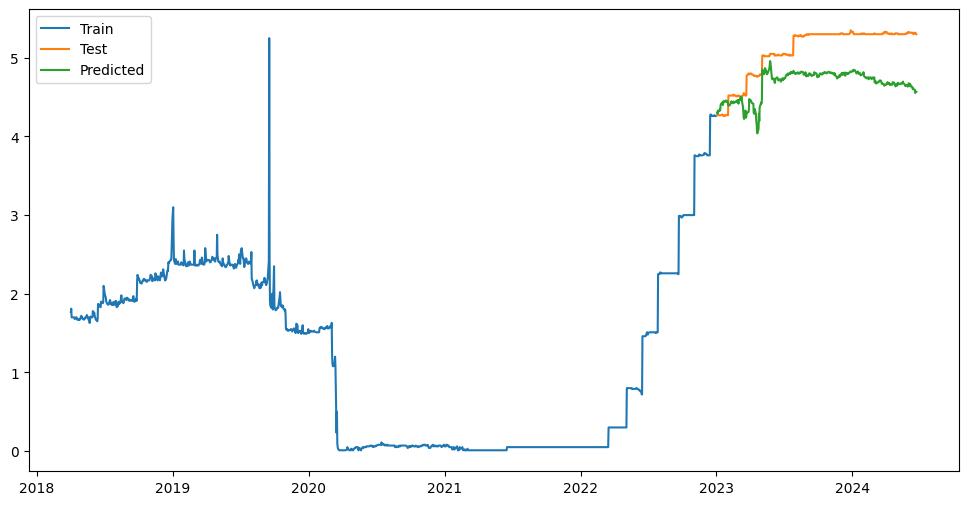

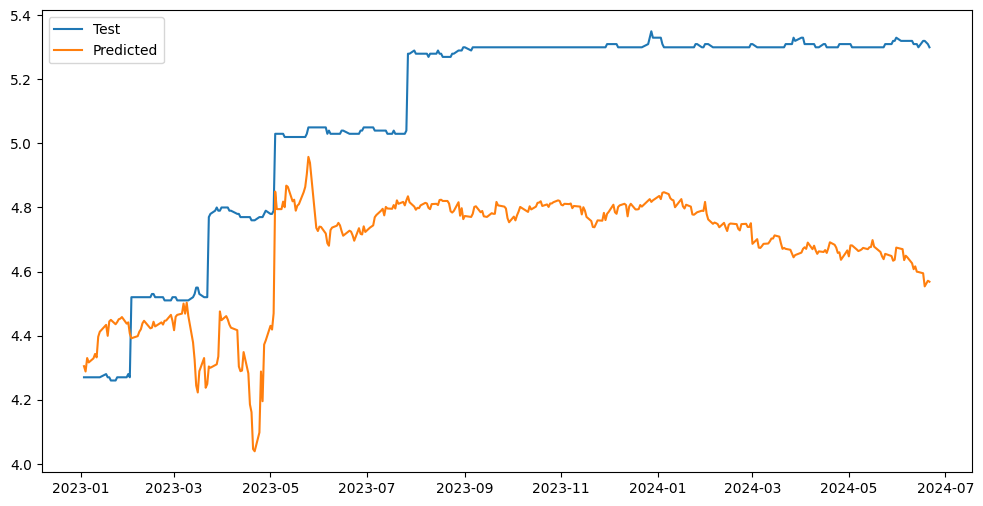

Mean Squared Error: 0.2245
Mean Absolute Error: 0.4356
R2 Score: -1.1521
Root Mean Squared Error: 0.4738
Adjusted R-squared: -1.2634


In [16]:
# Predict using the test set
y_pred = model_v1_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test_scaled)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

print("\n\n")

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rsquare = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
n = len(y_test) # number of rows/observations
k = len(X_test_scaled[0]) # number of independent variables/features
arsquare = adjusted_r_squared(rsquare, n, k)

# Print the evaluation metrics
print(f'Mean Squared Error: {round(mse,4)}')
print(f'Mean Absolute Error: {round(mae,4)}')
print(f'R2 Score: {round(rsquare,4)}')
print(f'Root Mean Squared Error: {round(rmse,4)}')
print(f'Adjusted R-squared: {round(arsquare,4)}')

# Model 2: ARIMAX With Additional Features

## Add PPI

In [17]:
ppi_data = {
    'Year': [2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Jan': [114.8, 117, 119.3, 121.2, 133.576, 141.286, 142.683],
    'Feb': [115.1, 117.2, 118.6, 122, 134.821, 141.237, 143.509],
    'Mar': [115.3, 117.6, 118, 122.8, 137.041, 140.738, 143.410],
    'Apr': [115.5, 118.2, 116.6, 124.1, 137.805, 140.977, 144.119],
    'May': [115.9, 118.3, 117.2, 125.3, 139.026, 140.664, 144.079],
    'Jun': [116.3, 118.2, 117.5, 126.2, 140.238, 140.672, 144.402],
    'Jul': [116.4, 118.5, 118.2, 127.504, 139.837, 141.461, None],
    'Aug': [116.5, 118.6, 118.4, 128.574, 139.721, 142.353, None],
    'Sep': [116.7, 118.3, 118.7, 129.188, 140.137, 142.658, None],
    'Oct': [117.5, 118.8, 119.4, 130.061, 140.666, 142.191, None],
    'Nov': [117.4, 118.6, 119.5, 131.455, 141.18, 142.267, None],
    'Dec': [117.4, 119, 120, 132.224, 140.696, 142.17, None]
}

# Converting PPI data to DataFrame
ppi_df = pd.DataFrame(ppi_data)

# Melting the PPI DataFrame to long format
ppi_long_df = pd.melt(ppi_df, id_vars=['Year'], var_name='Month', value_name='PPI')

# Mapping month names to numbers
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
ppi_long_df['Month'] = ppi_long_df['Month'].map(month_mapping)

# Creating a 'Day' column with value 1 for each row
ppi_long_df['Day'] = 1

# Creating a date column in the PPI DataFrame
ppi_long_df['Date'] = pd.to_datetime(ppi_long_df[['Year', 'Month', 'Day']])

# Dropping unnecessary columns
ppi_long_df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)

# Setting the Date as the index
ppi_long_df.set_index('Date', inplace=True)

# Reindexing to fill in missing dates with forward fill for the last known PPI value of each month
ppi_long_df = ppi_long_df.resample('D').ffill()

# Reset the index to have Date as a column again
ppi_long_df.reset_index(inplace=True)

ppi_long_df['Date'] = pd.to_datetime(ppi_long_df['Date'])
df_merged7 = pd.merge(df_merged6, ppi_long_df[['Date', 'PPI']], on='Date', how='inner')

## Add Unemployment

In [18]:
unemp_data = {
    'Year': [2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Jan': [4, 4, 3.6, 6.4, 4, 3.4, 3.7],
    'Feb': [4.1, 3.8, 3.5, 6.2, 3.8, 3.6, 3.9],
    'Mar': [4, 3.8, 4.4, 6.1, 3.6, 3.5, 3.8],
    'Apr': [4, 3.7, 14.8, 6.1, 3.7, 3.4, 3.9],
    'May': [3.8, 3.6, 13.2, 5.8, 3.6, 3.7, 4],
    'Jun': [4, 3.6, 11, 5.9, 3.6, 3.6, 4.1],
    'Jul': [3.8, 3.7, 10.2, 5.4, 3.5, 3.5, None],
    'Aug': [3.8, 3.6, 8.4, 5.1, 3.6, 3.8, None],
    'Sep': [3.7, 3.5, 7.8, 4.7, 3.5, 3.8, None],
    'Oct': [3.8, 3.6, 6.8, 4.5, 3.6, 3.8, None],
    'Nov': [3.8, 3.6, 6.7, 4.1, 3.6, 3.7, None],
    'Dec': [3.9, 3.6, 6.7, 3.9, 3.5, 3.7, None]
}

# Converting Unempl data to DataFrame
unemp_df = pd.DataFrame(unemp_data)

# Melting the Unempl DataFrame to long format
unemp_long_df = pd.melt(unemp_df, id_vars=['Year'], var_name='Month', value_name='Unemployment')

# Maunempng month names to numbers
month_maunempng = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
unemp_long_df['Month'] = unemp_long_df['Month'].map(month_maunempng)

# Creating a 'Day' column with value 1 for each row
unemp_long_df['Day'] = 1

# Creating a date column in the Unempl DataFrame
unemp_long_df['Date'] = pd.to_datetime(unemp_long_df[['Year', 'Month', 'Day']])

# Drounempng unnecessary columns
unemp_long_df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)

# Setting the Date as the index
unemp_long_df.set_index('Date', inplace=True)

# Reindexing to fill in missing dates with forward fill for the last known Unempl value of each month
unemp_long_df = unemp_long_df.resample('D').ffill()

# Reset the index to have Date as a column again
unemp_long_df.reset_index(inplace=True)

unemp_long_df['Date'] = pd.to_datetime(unemp_long_df['Date'])
df_merged8 = pd.merge(df_merged7, unemp_long_df[['Date', 'Unemployment']], on='Date', how='inner')

## V2 Feature Set

In [19]:
df_model_v2 = df_merged8.copy()
df_model_v2 = df_model_v2.drop(columns=[ 'Rate Type','1st Percentile (%)', '25th Percentile (%)', '75th Percentile (%)', '99th Percentile (%)',
                                  '4 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT', '26 WEEKS COUPON EQUIVALENT', '52 WEEKS COUPON EQUIVALENT'])

# Set the 'Date' column as the index
df_model_v2.set_index('Date', inplace=True)
df_model_v2 = df_model_v2.sort_index(ascending=True)
df_model_v2

# Replace 'ND' with NaN and fill with a method or drop rows
df_model_v2.replace('ND', np.nan, inplace=True)

print("NaN values in original features dataframe before dropping:")
print(df_model_v2.isna().sum())

# Drop rows with NaN values in the dataframe
df_model_v2.dropna(inplace=True)

cols = ['SPOT EXCHANGE RATE - EURO AREA ', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)', 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ']
df_model_v2[cols] = df_model_v2[cols].astype(float)

# Re-check for any remaining NaN values
print("\n\nNaN values in original features dataframe after dropping:")
print(df_model_v2.isna().sum())

NaN values in original features dataframe before dropping:
Rate (%)                                                          0
Volume ($Billions)                                                0
LT COMPOSITE (>10 Yrs)                                            0
TREASURY 20-Yr CMT                                                0
Yield Spread (4W - 52W)                                           0
Yield Spread (13W - 52W)                                          0
Yield Spread (26W - 52W)                                          0
Yield Spread (10Y - 4W)                                           0
Yield Spread (20Y - 4W)                                           0
Yield Spread (10Y - 52W)                                          0
Yield Spread (20Y - 52W)                                          0
CPI                                                               0
SPX                                                               0
NASDAQ                                                   

## Training

In [20]:
# Split into train and test

train = df_model_v2[:'2022-12-31']
test = df_model_v2['2023-01-01':]

# Split into X & y

y_train = train['Rate (%)']
X_train = train.drop(columns=['Rate (%)'])
y_test = test['Rate (%)']
X_test = test.drop(columns=['Rate (%)'])

# Scaling values

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# model definition

model_v2 = SARIMAX(y_train, exog= X_train_scaled, order= (1,1,1), seasonal_order= (0,0,0,0)) # order was (1,1,1) seasonal_order was (0,0,0,0)
model_v2_fit = model_v2.fit(disp=False)
print(model_v2_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               Rate (%)   No. Observations:                 1181
Model:               SARIMAX(1, 1, 1)   Log Likelihood           -12781182.832
Date:                Fri, 16 Aug 2024   AIC                       25562411.665
Time:                        01:01:30   BIC                       25562528.350
Sample:                             0   HQIC                      25562455.656
                               - 1181                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1751   4.07e-05   4303.335      0.000       0.175       0.175
x2          3.783e+13   9.64e-06   3.92e+18      0.000    3.78e+13    3.78e+13
x3         -3.909e+13   8.73e-06  -4.48e+18      0.0

## Testing

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


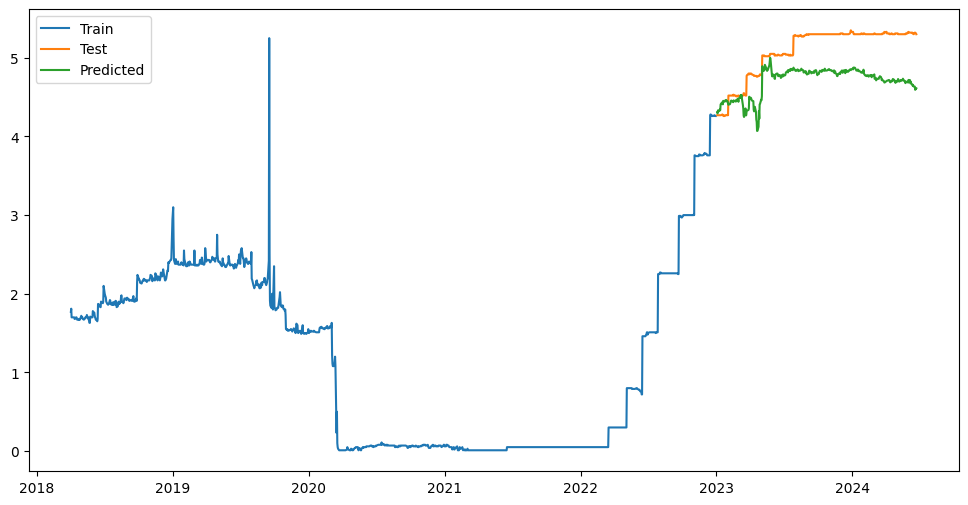

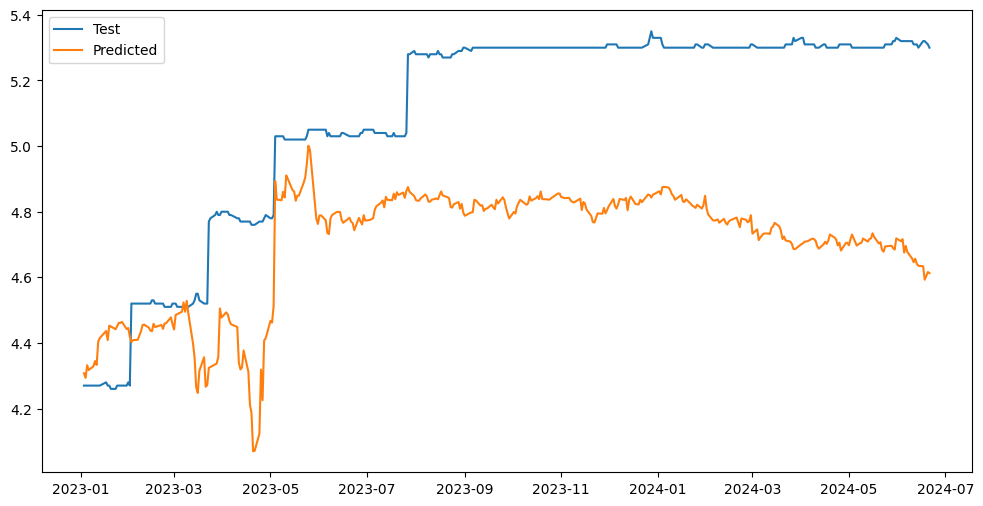

Mean Squared Error: 0.1956
Mean Absolute Error: 0.4038
R2 Score: -0.8758
Root Mean Squared Error: 0.4423
Adjusted R-squared: -0.9842


In [21]:
# Predict using the test set
y_pred = model_v2_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test_scaled)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

print("\n\n")

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rsquare = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
n = len(y_test) # number of rows/observations
k = len(X_test_scaled[0]) # number of independent variables/features
arsquare = adjusted_r_squared(rsquare, n, k)

# Print the evaluation metrics
print(f'Mean Squared Error: {round(mse,4)}')
print(f'Mean Absolute Error: {round(mae,4)}')
print(f'R2 Score: {round(rsquare,4)}')
print(f'Root Mean Squared Error: {round(rmse,4)}')
print(f'Adjusted R-squared: {round(arsquare,4)}')

# Model 3: SARIMAX Model

## Re-introducing V2 Feature Set as V3

In [22]:
df_model_v3 = df_merged8.copy()
df_model_v3 = df_model_v3.drop(columns=[ 'Rate Type','1st Percentile (%)', '25th Percentile (%)', '75th Percentile (%)', '99th Percentile (%)',
                                  '4 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT', '26 WEEKS COUPON EQUIVALENT', '52 WEEKS COUPON EQUIVALENT'])

# Set the 'Date' column as the index
df_model_v3.set_index('Date', inplace=True)
df_model_v3 = df_model_v3.sort_index(ascending=True)
df_model_v3

# Replace 'ND' with NaN and fill with a method or drop rows
df_model_v3.replace('ND', np.nan, inplace=True)

print("NaN values in original features dataframe before dropping:")
print(df_model_v3.isna().sum())

# Drop rows with NaN values in the dataframe
df_model_v3.dropna(inplace=True)

cols = ['SPOT EXCHANGE RATE - EURO AREA ', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)', 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ']
df_model_v3[cols] = df_model_v3[cols].astype(float)

# Re-check for any remaining NaN values
print("\n\nNaN values in original features dataframe after dropping:")
print(df_model_v3.isna().sum())

NaN values in original features dataframe before dropping:
Rate (%)                                                          0
Volume ($Billions)                                                0
LT COMPOSITE (>10 Yrs)                                            0
TREASURY 20-Yr CMT                                                0
Yield Spread (4W - 52W)                                           0
Yield Spread (13W - 52W)                                          0
Yield Spread (26W - 52W)                                          0
Yield Spread (10Y - 4W)                                           0
Yield Spread (20Y - 4W)                                           0
Yield Spread (10Y - 52W)                                          0
Yield Spread (20Y - 52W)                                          0
CPI                                                               0
SPX                                                               0
NASDAQ                                                   

## Checking for Seasonality

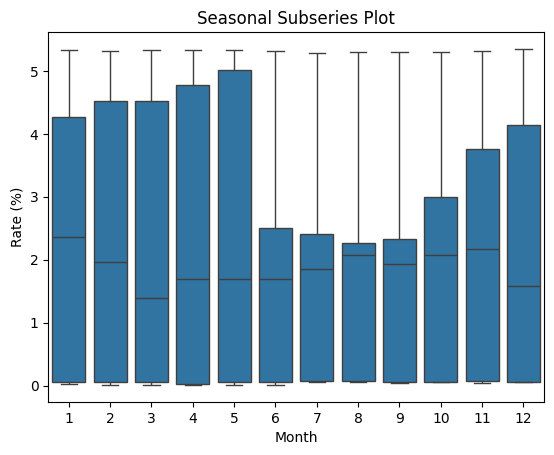

In [23]:
df_seasons= df_model_v3.copy()

df_seasons['Month'] = df_seasons.index.month
sns.boxplot(x='Month', y='Rate (%)', data=df_seasons.reset_index())
plt.title('Seasonal Subseries Plot')
plt.xlabel('Month')
plt.ylabel('Rate (%)')
plt.show()

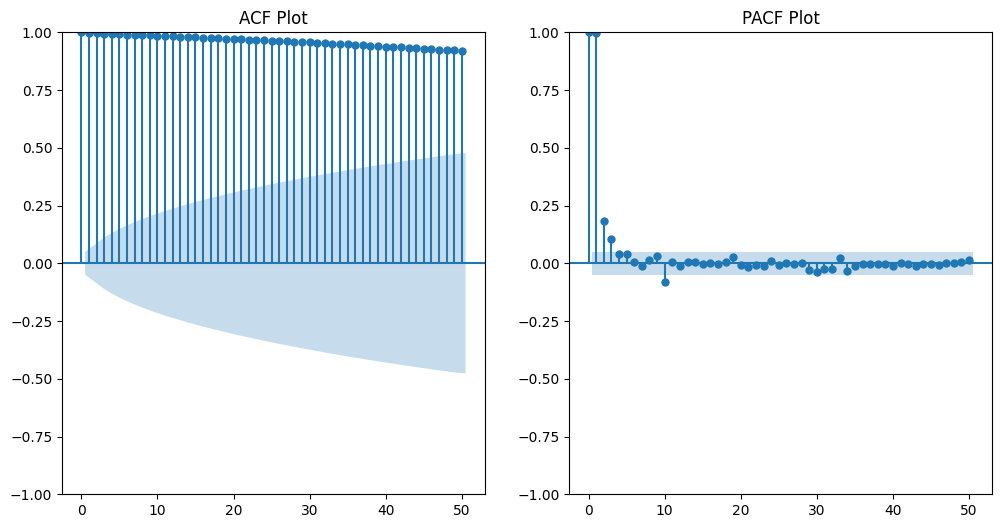

In [24]:
# Autocorrelation Function (ACF) Plot

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(df_seasons['Rate (%)'], lags=50, ax=plt.gca())
plt.title('ACF Plot')

#  Partial Autocorrelation Function (PACF)

plt.subplot(1, 2, 2)
plot_pacf(df_seasons['Rate (%)'], lags=50, ax=plt.gca())
plt.title('PACF Plot')
plt.show()

In [25]:
# Ljung-Box Test

from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(df_seasons['Rate (%)'], lags=[12], return_df=True)
print(lb_test)

         lb_stat  lb_pvalue
12  18284.584561        0.0


## Training

In [26]:
# Split into train and test

train = df_model_v3[:'2022-12-31']
test = df_model_v3['2023-01-01':]

# Split into X & y

y_train = train['Rate (%)']
X_train = train.drop(columns=['Rate (%)'])
y_test = test['Rate (%)']
X_test = test.drop(columns=['Rate (%)'])

# Scaling values

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# model definition

model_v2 = SARIMAX(y_train, exog= X_train_scaled, order= (0,1,0), seasonal_order= (1,1,2,6))
model_v2_fit = model_v2.fit(disp=False)
print(model_v2_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                       SARIMAX Results                                        
Dep. Variable:                               Rate (%)   No. Observations:                 1181
Model:             SARIMAX(0, 1, 0)x(1, 1, [1, 2], 6)   Log Likelihood                 666.024
Date:                                Fri, 16 Aug 2024   AIC                          -1284.048
Time:                                        01:02:40   BIC                          -1162.412
Sample:                                             0   HQIC                         -1238.179
                                               - 1181                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1653      0.163      1.016      0.309      -0.153       0.484
x2 

## Testing

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


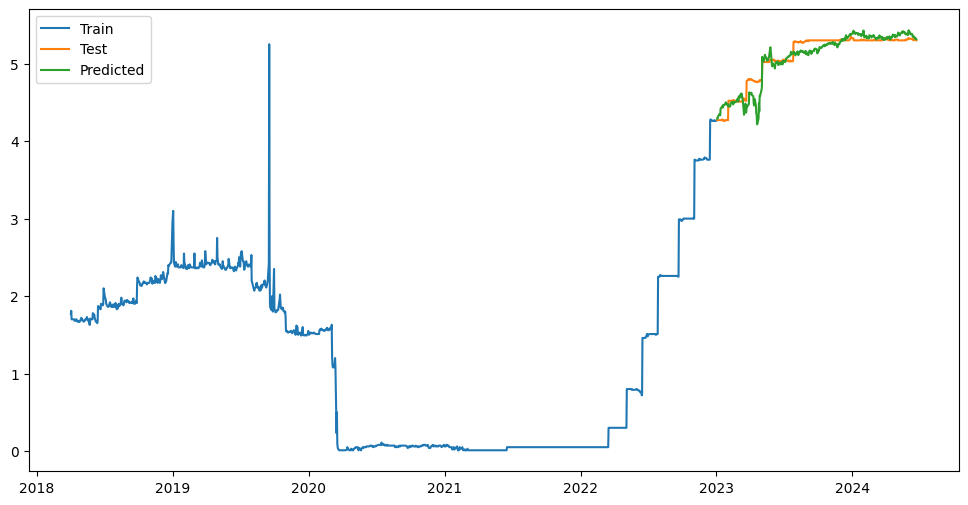

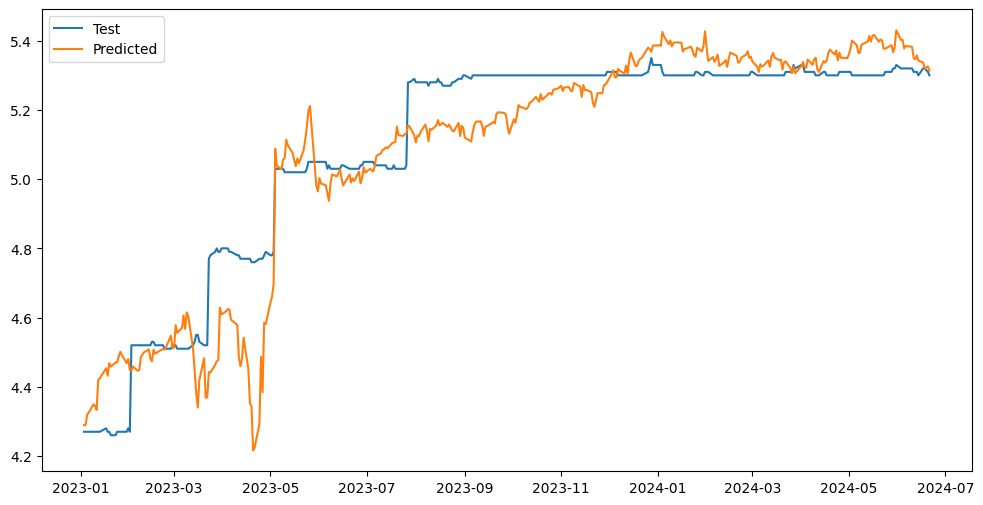

Mean Squared Error: 0.0144
Mean Absolute Error: 0.0881
R2 Score: 0.8624
Root Mean Squared Error: 0.1198
Adjusted R-squared: 0.8544


In [27]:
# Predict using the test set
y_pred = model_v2_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test_scaled)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

print("\n\n")

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rsquare = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
n = len(y_test) # number of rows/observations
k = len(X_test_scaled[0]) # number of independent variables/features
arsquare = adjusted_r_squared(rsquare, n, k)

# Print the evaluation metrics
print(f'Mean Squared Error: {round(mse,4)}')
print(f'Mean Absolute Error: {round(mae,4)}')
print(f'R2 Score: {round(rsquare,4)}')
print(f'Root Mean Squared Error: {round(rmse,4)}')
print(f'Adjusted R-squared: {round(arsquare,4)}')

# Model 4: SARIMAX Model with Lag and Difference Features

## Functions to check for Stationarity

### Augmented Dickey Fuller (“ADF”) test

In [28]:
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out['Critical Value (%s)' % key] = value
    print(f'===Augmented Dickey-Fuller Test: {title}===')
    print(out.to_string())
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary")

### Kwiatkowski-Phillips-Schmidt-Shin (“KPSS”) test

In [29]:
def kpss_test(series, title=''):
    result = kpss(series.dropna(), regression='c')
    labels = ['KPSS Test Statistic', 'p-value', '#Lags Used']
    out = pd.Series(result[0:3], index=labels)
    for key, value in result[3].items():
        out['Critical Value (%s)' % key] = value
    print(f'===KPSS Test: {title}===')
    print(out.to_string())
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary")
    else:
        print("Weak evidence against the null hypothesis, time series is stationary")

## Re-introducing V2 Feature Set as V4

In [30]:
df_model_v4 = df_merged8.copy()
df_model_v4 = df_model_v4.drop(columns=[ 'Rate Type','1st Percentile (%)', '25th Percentile (%)', '75th Percentile (%)', '99th Percentile (%)',
                                  '4 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT', '26 WEEKS COUPON EQUIVALENT', '52 WEEKS COUPON EQUIVALENT'])

# Set the 'Date' column as the index
df_model_v4.set_index('Date', inplace=True)
df_model_v4 = df_model_v4.sort_index(ascending=True)
df_model_v4

# Replace 'ND' with NaN and fill with a method or drop rows
df_model_v4.replace('ND', np.nan, inplace=True)

print("NaN values in original features dataframe before dropping:")
print(df_model_v4.isna().sum())

# Drop rows with NaN values in the dataframe
df_model_v4.dropna(inplace=True)

cols = ['SPOT EXCHANGE RATE - EURO AREA ', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)', 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ']
df_model_v4[cols] = df_model_v4[cols].astype(float)

# Re-check for any remaining NaN values
print("\n\nNaN values in original features dataframe after dropping:")
print(df_model_v4.isna().sum())

NaN values in original features dataframe before dropping:
Rate (%)                                                          0
Volume ($Billions)                                                0
LT COMPOSITE (>10 Yrs)                                            0
TREASURY 20-Yr CMT                                                0
Yield Spread (4W - 52W)                                           0
Yield Spread (13W - 52W)                                          0
Yield Spread (26W - 52W)                                          0
Yield Spread (10Y - 4W)                                           0
Yield Spread (20Y - 4W)                                           0
Yield Spread (10Y - 52W)                                          0
Yield Spread (20Y - 52W)                                          0
CPI                                                               0
SPX                                                               0
NASDAQ                                                   

## Stationarity Checks

In [31]:
df_stationary = df_model_v4.copy()

# Function to check stationarity and apply differencing
def ensure_stationarity(series, name):
    try:
        print(f"\nChecking stationarity for {name}:\n")
        adf_test(series, title=name)
        print("\n")
        kpss_test(series, title=name)

        # Check stationarity after the first differencing if necessary
        if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
            print(f"\n{name} is not stationary. Applying first differencing.\n")
            series = series.diff().dropna()

            # Ensure no infinite or NaN values
            if np.isinf(series).any() or series.isna().any():
                series.replace([np.inf, -np.inf], np.nan, inplace=True)
                series.dropna(inplace=True)

            print(f"\nRe-checking stationarity for {name} after first differencing:\n")
            adf_test(series, title=f"{name} - First Differenced")
            print("\n")
            kpss_test(series, title=f"{name} - First Differenced")

            # Check stationarity after the second differencing if necessary
            if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
                print(f"\n{name} is still not stationary. Applying second differencing.\n")
                series = series.diff().dropna()

                # Ensure no infinite or NaN values
                if np.isinf(series).any() or series.isna().any():
                    series.replace([np.inf, -np.inf], np.nan, inplace=True)
                    series.dropna(inplace=True)

                print(f"\nRe-checking stationarity for {name} after second differencing:\n")
                adf_test(series, title=f"{name} - Second Differenced")
                print("\n")
                kpss_test(series, title=f"{name} - Second Differenced")
            else:
                print(f"\n{name} is stationary after first differencing.\n")
        else:
            print(f"{name} is already stationary.\n")
    except Exception as e:
        print(f"An error occurred while processing {name}: {e}")

    return series

# Apply the function to each explanatory variable
for col in df_stationary.columns:
    if col not in ['Rate (%)', 'Rate (%) - First Differenced', 'Rate (%) - Second Differenced']:
        df_stationary[col] = ensure_stationarity(df_model_v3[col], col)

# Now, let's ensure the 'Rate (%)' column is also stationary, applying the same procedure
df_stationary['Rate (%)'] = ensure_stationarity(df_model_v3['Rate (%)'], 'Rate (%)')

print("Stationarity check and differencing completed.")


Checking stationarity for Volume ($Billions):

===Augmented Dickey-Fuller Test: Volume ($Billions)===
ADF Test Statistic                0.776581
p-value                           0.991249
#Lags Used                       13.000000
Number of Observations Used    1534.000000
Critical Value (1%)              -3.434620
Critical Value (5%)              -2.863426
Critical Value (10%)             -2.567774
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Volume ($Billions)===
KPSS Test Statistic       2.145532
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Volume ($Billions) is not stationary. Applying first differencing.


Re-checking stationarity for Volume ($Billi

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: Volume ($Billions) - First Differenced===
ADF Test Statistic            -1.265209e+01
p-value                        1.361381e-23
#Lags Used                     1.200000e+01
Number of Observations Used    1.534000e+03
Critical Value (1%)           -3.434620e+00
Critical Value (5%)           -2.863426e+00
Critical Value (10%)          -2.567774e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Volume ($Billions) - First Differenced===
KPSS Test Statistic       0.381913
p-value                   0.084951
#Lags Used               21.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothesis, time series is stationary

Volume ($Billions) is stationary after first differencing.


Checking stationarity for LT COMPOSITE (>10 Yrs):

===Augmented Dickey

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-31-d26c15019450>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



LT COMPOSITE (>10 Yrs) is not stationary. Applying first differencing.


Re-checking stationarity for LT COMPOSITE (>10 Yrs) after first differencing:

===Augmented Dickey-Fuller Test: LT COMPOSITE (>10 Yrs) - First Differenced===
ADF Test Statistic              -29.642217
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1545.000000
Critical Value (1%)              -3.434590
Critical Value (5%)              -2.863413
Critical Value (10%)             -2.567767
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: LT COMPOSITE (>10 Yrs) - First Differenced===
KPSS Test Statistic      0.312068
p-value                  0.100000
#Lags Used               1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: TREASURY 20-Yr CMT - First Differenced===
KPSS Test Statistic      0.311121
p-value                  0.100000
#Lags Used               0.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series is stationary

TREASURY 20-Yr CMT is stationary after first differencing.


Checking stationarity for Yield Spread (4W - 52W):

===Augmented Dickey-Fuller Test: Yield Spread (4W - 52W)===
ADF Test Statistic               -1.761954
p-value                           0.399507
#Lags Used                       23.000000
Number of Observations Used    1524.000000
Critical Value (1%)              -3.434648
Critical Value (5%)              -2.863438
Critical Value (10%)             -2.567781
Weak evidence against the null hypothesis, tim

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-31-d26c15019450>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



Yield Spread (4W - 52W) is not stationary. Applying first differencing.


Re-checking stationarity for Yield Spread (4W - 52W) after first differencing:

===Augmented Dickey-Fuller Test: Yield Spread (4W - 52W) - First Differenced===
ADF Test Statistic            -1.038358e+01
p-value                        2.108099e-18
#Lags Used                     2.200000e+01
Number of Observations Used    1.524000e+03
Critical Value (1%)           -3.434648e+00
Critical Value (5%)           -2.863438e+00
Critical Value (10%)          -2.567781e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Yield Spread (4W - 52W) - First Differenced===
KPSS Test Statistic       0.052424
p-value                   0.100000
#Lags Used               19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypot

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-31-d26c15019450>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:


===Augmented Dickey-Fuller Test: Yield Spread (13W - 52W)===
ADF Test Statistic               -1.765429
p-value                           0.397755
#Lags Used                       23.000000
Number of Observations Used    1524.000000
Critical Value (1%)              -3.434648
Critical Value (5%)              -2.863438
Critical Value (10%)             -2.567781
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Yield Spread (13W - 52W)===
KPSS Test Statistic       0.551603
p-value                   0.030044
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Yield Spread (13W - 52W) is not stationary. Applying first differencing.


Re-checking stationarity for Yield Spread (13W - 52W) after first differe

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-31-d26c15019450>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: Yield Spread (26W - 52W) - First Differenced===
ADF Test Statistic            -8.362724e+00
p-value                        2.795353e-13
#Lags Used                     2.200000e+01
Number of Observations Used    1.524000e+03
Critical Value (1%)           -3.434648e+00
Critical Value (5%)           -2.863438e+00
Critical Value (10%)          -2.567781e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Yield Spread (26W - 52W) - First Differenced===
KPSS Test Statistic       0.065045
p-value                   0.100000
#Lags Used               20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothesis, time series is stationary

Yield Spread (26W - 52W) is stationary after first differencing.


Checking stationarity for Yield Spread (10Y - 4W):



<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-31-d26c15019450>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



Yield Spread (10Y - 4W) is not stationary. Applying first differencing.


Re-checking stationarity for Yield Spread (10Y - 4W) after first differencing:

===Augmented Dickey-Fuller Test: Yield Spread (10Y - 4W) - First Differenced===
ADF Test Statistic            -8.381766e+00
p-value                        2.499047e-13
#Lags Used                     2.300000e+01
Number of Observations Used    1.523000e+03
Critical Value (1%)           -3.434651e+00
Critical Value (5%)           -2.863440e+00
Critical Value (10%)          -2.567781e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Yield Spread (10Y - 4W) - First Differenced===
KPSS Test Statistic       0.133822
p-value                   0.100000
#Lags Used               17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypot

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-31-d26c15019450>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')




Re-checking stationarity for Yield Spread (20Y - 4W) after first differencing:

===Augmented Dickey-Fuller Test: Yield Spread (20Y - 4W) - First Differenced===
ADF Test Statistic            -8.370157e+00
p-value                        2.675730e-13
#Lags Used                     2.300000e+01
Number of Observations Used    1.523000e+03
Critical Value (1%)           -3.434651e+00
Critical Value (5%)           -2.863440e+00
Critical Value (10%)          -2.567781e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Yield Spread (20Y - 4W) - First Differenced===
KPSS Test Statistic       0.13947
p-value                   0.10000
#Lags Used               17.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
Weak evidence against the null hypothesis, time series is stationary

Yield Spread (20Y - 4W) is stationary after fi

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-31-d26c15019450>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')




===KPSS Test: Yield Spread (10Y - 52W)===
KPSS Test Statistic       2.256507
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Yield Spread (10Y - 52W) is not stationary. Applying first differencing.


Re-checking stationarity for Yield Spread (10Y - 52W) after first differencing:

===Augmented Dickey-Fuller Test: Yield Spread (10Y - 52W) - First Differenced===
ADF Test Statistic              -21.810181
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    1543.000000
Critical Value (1%)              -3.434595
Critical Value (5%)              -2.863415
Critical Value (10%)             -2.567768
Strong evidence against the null hypothesis, reject the null hypothesis. Dat

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-31-d26c15019450>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: Yield Spread (20Y - 52W)===
ADF Test Statistic               -0.677646
p-value                           0.852455
#Lags Used                        4.000000
Number of Observations Used    1543.000000
Critical Value (1%)              -3.434595
Critical Value (5%)              -2.863415
Critical Value (10%)             -2.567768
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Yield Spread (20Y - 52W)===
KPSS Test Statistic       2.040066
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Yield Spread (20Y - 52W) is not stationary. Applying first differencing.


Re-checking stationarity for Yield Spread (20Y - 52W) after first differe

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-31-d26c15019450>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



Yield Spread (20Y - 52W) is stationary after first differencing.


Checking stationarity for CPI:

===Augmented Dickey-Fuller Test: CPI===
ADF Test Statistic                0.625158
p-value                           0.988220
#Lags Used                       23.000000
Number of Observations Used    1524.000000
Critical Value (1%)              -3.434648
Critical Value (5%)              -2.863438
Critical Value (10%)             -2.567781
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: CPI===
KPSS Test Statistic       5.8641
p-value                   0.0100
#Lags Used               25.0000
Critical Value (10%)      0.3470
Critical Value (5%)       0.4630
Critical Value (2.5%)     0.5740
Critical Value (1%)       0.7390
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

CPI is not stationary. Applying first differencing.


Re-checking stationarity for CPI after first diffe

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2171: RuntimeWarning: divide by zero encountered in scalar divide
  s_hat = s1 / s0
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: SPX - First Differenced===
ADF Test Statistic            -1.219072e+01
p-value                        1.287629e-22
#Lags Used                     8.000000e+00
Number of Observations Used    1.538000e+03
Critical Value (1%)           -3.434609e+00
Critical Value (5%)           -2.863421e+00
Critical Value (10%)          -2.567771e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: SPX - First Differenced===
KPSS Test Statistic      0.073802
p-value                  0.100000
#Lags Used               0.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series is stationary

SPX is stationary after first differencing.


Checking stationarity for NASDAQ:

===Augmented Dickey-Fuller Test: NASDAQ===
ADF Test Statistic               -0.461922
p

<ipython-input-31-d26c15019450>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: NASDAQ - First Differenced===
ADF Test Statistic            -1.260440e+01
p-value                        1.708370e-23
#Lags Used                     8.000000e+00
Number of Observations Used    1.538000e+03
Critical Value (1%)           -3.434609e+00
Critical Value (5%)           -2.863421e+00
Critical Value (10%)          -2.567771e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: NASDAQ - First Differenced===
KPSS Test Statistic      0.103482
p-value                  0.100000
#Lags Used               3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series is stationary

NASDAQ is stationary after first differencing.


Checking stationarity for DJIA:

===Augmented Dickey-Fuller Test: DJIA===
ADF Test Statistic               -1.223

<ipython-input-31-d26c15019450>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



DJIA is not stationary. Applying first differencing.


Re-checking stationarity for DJIA after first differencing:

===Augmented Dickey-Fuller Test: DJIA - First Differenced===
ADF Test Statistic            -1.220702e+01
p-value                        1.187146e-22
#Lags Used                     8.000000e+00
Number of Observations Used    1.538000e+03
Critical Value (1%)           -3.434609e+00
Critical Value (5%)           -2.863421e+00
Critical Value (10%)          -2.567771e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: DJIA - First Differenced===
KPSS Test Statistic      0.032715
p-value                  0.100000
#Lags Used               5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series is stationary

DJIA is stationary after first differencing.


Ch

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-31-d26c15019450>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



SPOT EXCHANGE RATE - EURO AREA  is not stationary. Applying first differencing.


Re-checking stationarity for SPOT EXCHANGE RATE - EURO AREA  after first differencing:

===Augmented Dickey-Fuller Test: SPOT EXCHANGE RATE - EURO AREA  - First Differenced===
ADF Test Statistic            -1.748117e+01
p-value                        4.488492e-30
#Lags Used                     5.000000e+00
Number of Observations Used    1.541000e+03
Critical Value (1%)           -3.434601e+00
Critical Value (5%)           -2.863417e+00
Critical Value (10%)          -2.567769e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: SPOT EXCHANGE RATE - EURO AREA  - First Differenced===
KPSS Test Statistic      0.087167
p-value                  0.100000
#Lags Used               2.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak eviden

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-31-d26c15019450>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) is not stationary. Applying first differencing.


Re-checking stationarity for UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) after first differencing:

===Augmented Dickey-Fuller Test: UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) - First Differenced===
ADF Test Statistic            -1.243071e+01
p-value                        3.946348e-23
#Lags Used                     1.000000e+01
Number of Observations Used    1.536000e+03
Critical Value (1%)           -3.434614e+00
Critical Value (5%)           -2.863424e+00
Critical Value (10%)          -2.567773e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) - First Differenced===
KPSS Test Statistic      0.072704
p-value                  0.100000
#Lags Used               4.000000
Critical Value (10%)   

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-31-d26c15019450>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  is not stationary. Applying first differencing.


Re-checking stationarity for CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  after first differencing:

===Augmented Dickey-Fuller Test: CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - First Differenced===
ADF Test Statistic            -1.815930e+01
p-value                        2.463800e-30
#Lags Used                     3.000000e+00
Number of Observations Used    1.543000e+03
Critical Value (1%)           -3.434595e+00
Critical Value (5%)           -2.863415e+00
Critical Value (10%)          -2.567768e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - First Differenced===
KPSS Test Statistic      0.183514
p-value                  0.100000
#Lags Used               9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.5740

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-31-d26c15019450>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ===
ADF Test Statistic                0.827972
p-value                           0.992075
#Lags Used                        3.000000
Number of Observations Used    1544.000000
Critical Value (1%)              -3.434592
Critical Value (5%)              -2.863414
Critical Value (10%)             -2.567768
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ===
KPSS Test Statistic       4.756523
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

JAPAN -- SPOT EXCHANGE RATE, YEN/US$  is not stationary. Applying first differencing.


Re-checking stationarity for JAPAN

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-31-d26c15019450>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



JAPAN -- SPOT EXCHANGE RATE, YEN/US$  is stationary after first differencing.


Checking stationarity for PPI:

===Augmented Dickey-Fuller Test: PPI===
ADF Test Statistic                0.076163
p-value                           0.964395
#Lags Used                       23.000000
Number of Observations Used    1524.000000
Critical Value (1%)              -3.434648
Critical Value (5%)              -2.863438
Critical Value (10%)             -2.567781
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: PPI===
KPSS Test Statistic       5.793259
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

PPI is not stationary. Applying first differencing.


Re-checking stationarit

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-31-d26c15019450>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.



Unemployment is stationary after first differencing.


Checking stationarity for Rate (%):

===Augmented Dickey-Fuller Test: Rate (%)===
ADF Test Statistic                0.509674
p-value                           0.985164
#Lags Used                        9.000000
Number of Observations Used    1538.000000
Critical Value (1%)              -3.434609
Critical Value (5%)              -2.863421
Critical Value (10%)             -2.567771
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Rate (%)===
KPSS Test Statistic       2.705655
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Rate (%) is not stationary. Applying first differencing.


Re-checking stationarity for

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')


## Creating Lag & Difference Features

In [32]:
# Define a function to create differenced features
def create_lag_features(df, lags, cols):
    for col in cols:
        for lag in lags:
            df[f'{col} - Lag{lag}'] = df[col].shift(lag)
    return df

# Define a function to create differenced features
def create_differenced_features(df, cols_for_first_diff, cols_for_second_diff):
    for col in cols_for_first_diff:
        df[f'{col} - First Differenced'] = df[col].diff()
    for col in cols_for_second_diff:
        df[f'{col} - Second Differenced'] = df[col].diff().diff()
    return df

# Apply differencing and lag feature creation to the DataFrame
def prepare_features(df, cols_for_first_diff, cols_for_second_diff):
    # Columns for which lag features will be created
    cols_for_lags = list(set(df.columns) - set(cols_for_first_diff + cols_for_second_diff))
    cols_for_lags += cols_for_first_diff + cols_for_second_diff  # Ensure all relevant columns are included

    # Create differenced features
    df = create_differenced_features(df, cols_for_first_diff, cols_for_second_diff)

    # Create lag features
    lags = [1, 2, 3, 7, 14]  # Adjust the list of lags based on your needs
    df = create_lag_features(df, lags, cols_for_lags)

    # Drop rows with NaN values created by differencing and lagging
    df.dropna(inplace=True)

    return df

# Specify the columns for first and second differencing
cols_for_first_diff = ['Volume ($Billions)','LT COMPOSITE (>10 Yrs)','TREASURY 20-Yr CMT',
                       'Yield Spread (4W - 52W)','Yield Spread (13W - 52W)','Yield Spread (26W - 52W)',
                       'Yield Spread (10Y - 4W)','Yield Spread (20Y - 4W)','Yield Spread (10Y - 52W)',
                       'Yield Spread (20Y - 52W)','SPX','NASDAQ','DJIA','SPOT EXCHANGE RATE - EURO AREA ',
                       'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)','CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ',
                       'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ']  # Replace with actual column names that need first differencing

cols_for_second_diff = [#'4 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT',
                        #'26 WEEKS COUPON EQUIVALENT', '52 WEEKS COUPON EQUIVALENT',
                        'CPI', 'Rate (%)']  # Replace with actual column names that need second differencing

# Prepare the features
df_prepared = prepare_features(df_model_v4.copy(), cols_for_first_diff, cols_for_second_diff)

print("Feature preparation (differencing and lag features) completed.\n\n")
df_prepared.head()

Feature preparation (differencing and lag features) completed.




<ipython-input-32-70a79e2b3901>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col} - Lag{lag}'] = df[col].shift(lag)
<ipython-input-32-70a79e2b3901>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col} - Lag{lag}'] = df[col].shift(lag)
<ipython-input-32-70a79e2b3901>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, 

,Rate (%),Volume ($Billions),LT COMPOSITE (>10 Yrs),TREASURY 20-Yr CMT,Yield Spread (4W - 52W),Yield Spread (13W - 52W),Yield Spread (26W - 52W),Yield Spread (10Y - 4W),Yield Spread (20Y - 4W),Yield Spread (10Y - 52W),...,CPI - Lag1,CPI - Lag2,CPI - Lag3,CPI - Lag7,CPI - Lag14,Rate (%) - Lag1,Rate (%) - Lag2,Rate (%) - Lag3,Rate (%) - Lag7,Rate (%) - Lag14
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-20,1.67,340,3.09,3.04,0.56,0.39,0.19,1.45,1.40,0.89,...,250.546,250.546,250.546,250.546,250.546,1.67,1.69,1.70,1.70,1.77
2018-04-23,1.67,348,3.10,3.05,0.56,0.35,0.18,1.44,1.39,0.88,...,250.546,250.546,250.546,250.546,250.546,1.67,1.67,1.69,1.68,1.81
2018-04-24,1.68,339,3.12,3.08,0.55,0.38,0.20,1.42,1.38,0.87,...,250.546,250.546,250.546,250.546,250.546,1.67,1.67,1.67,1.68,1.70
2018-04-25,1.67,345,3.16,3.12,0.62,0.41,0.23,1.52,1.48,0.90,...,250.546,250.546,250.546,250.546,250.546,1.68,1.67,1.67,1.70,1.70
2018-04-26,1.67,333,3.13,3.08,0.64,0.43,0.23,1.52,1.47,0.88,...,250.546,250.546,250.546,250.546,250.546,1.67,1.68,1.67,1.70,1.70


## Using Correlation Matrix to Exclude Features

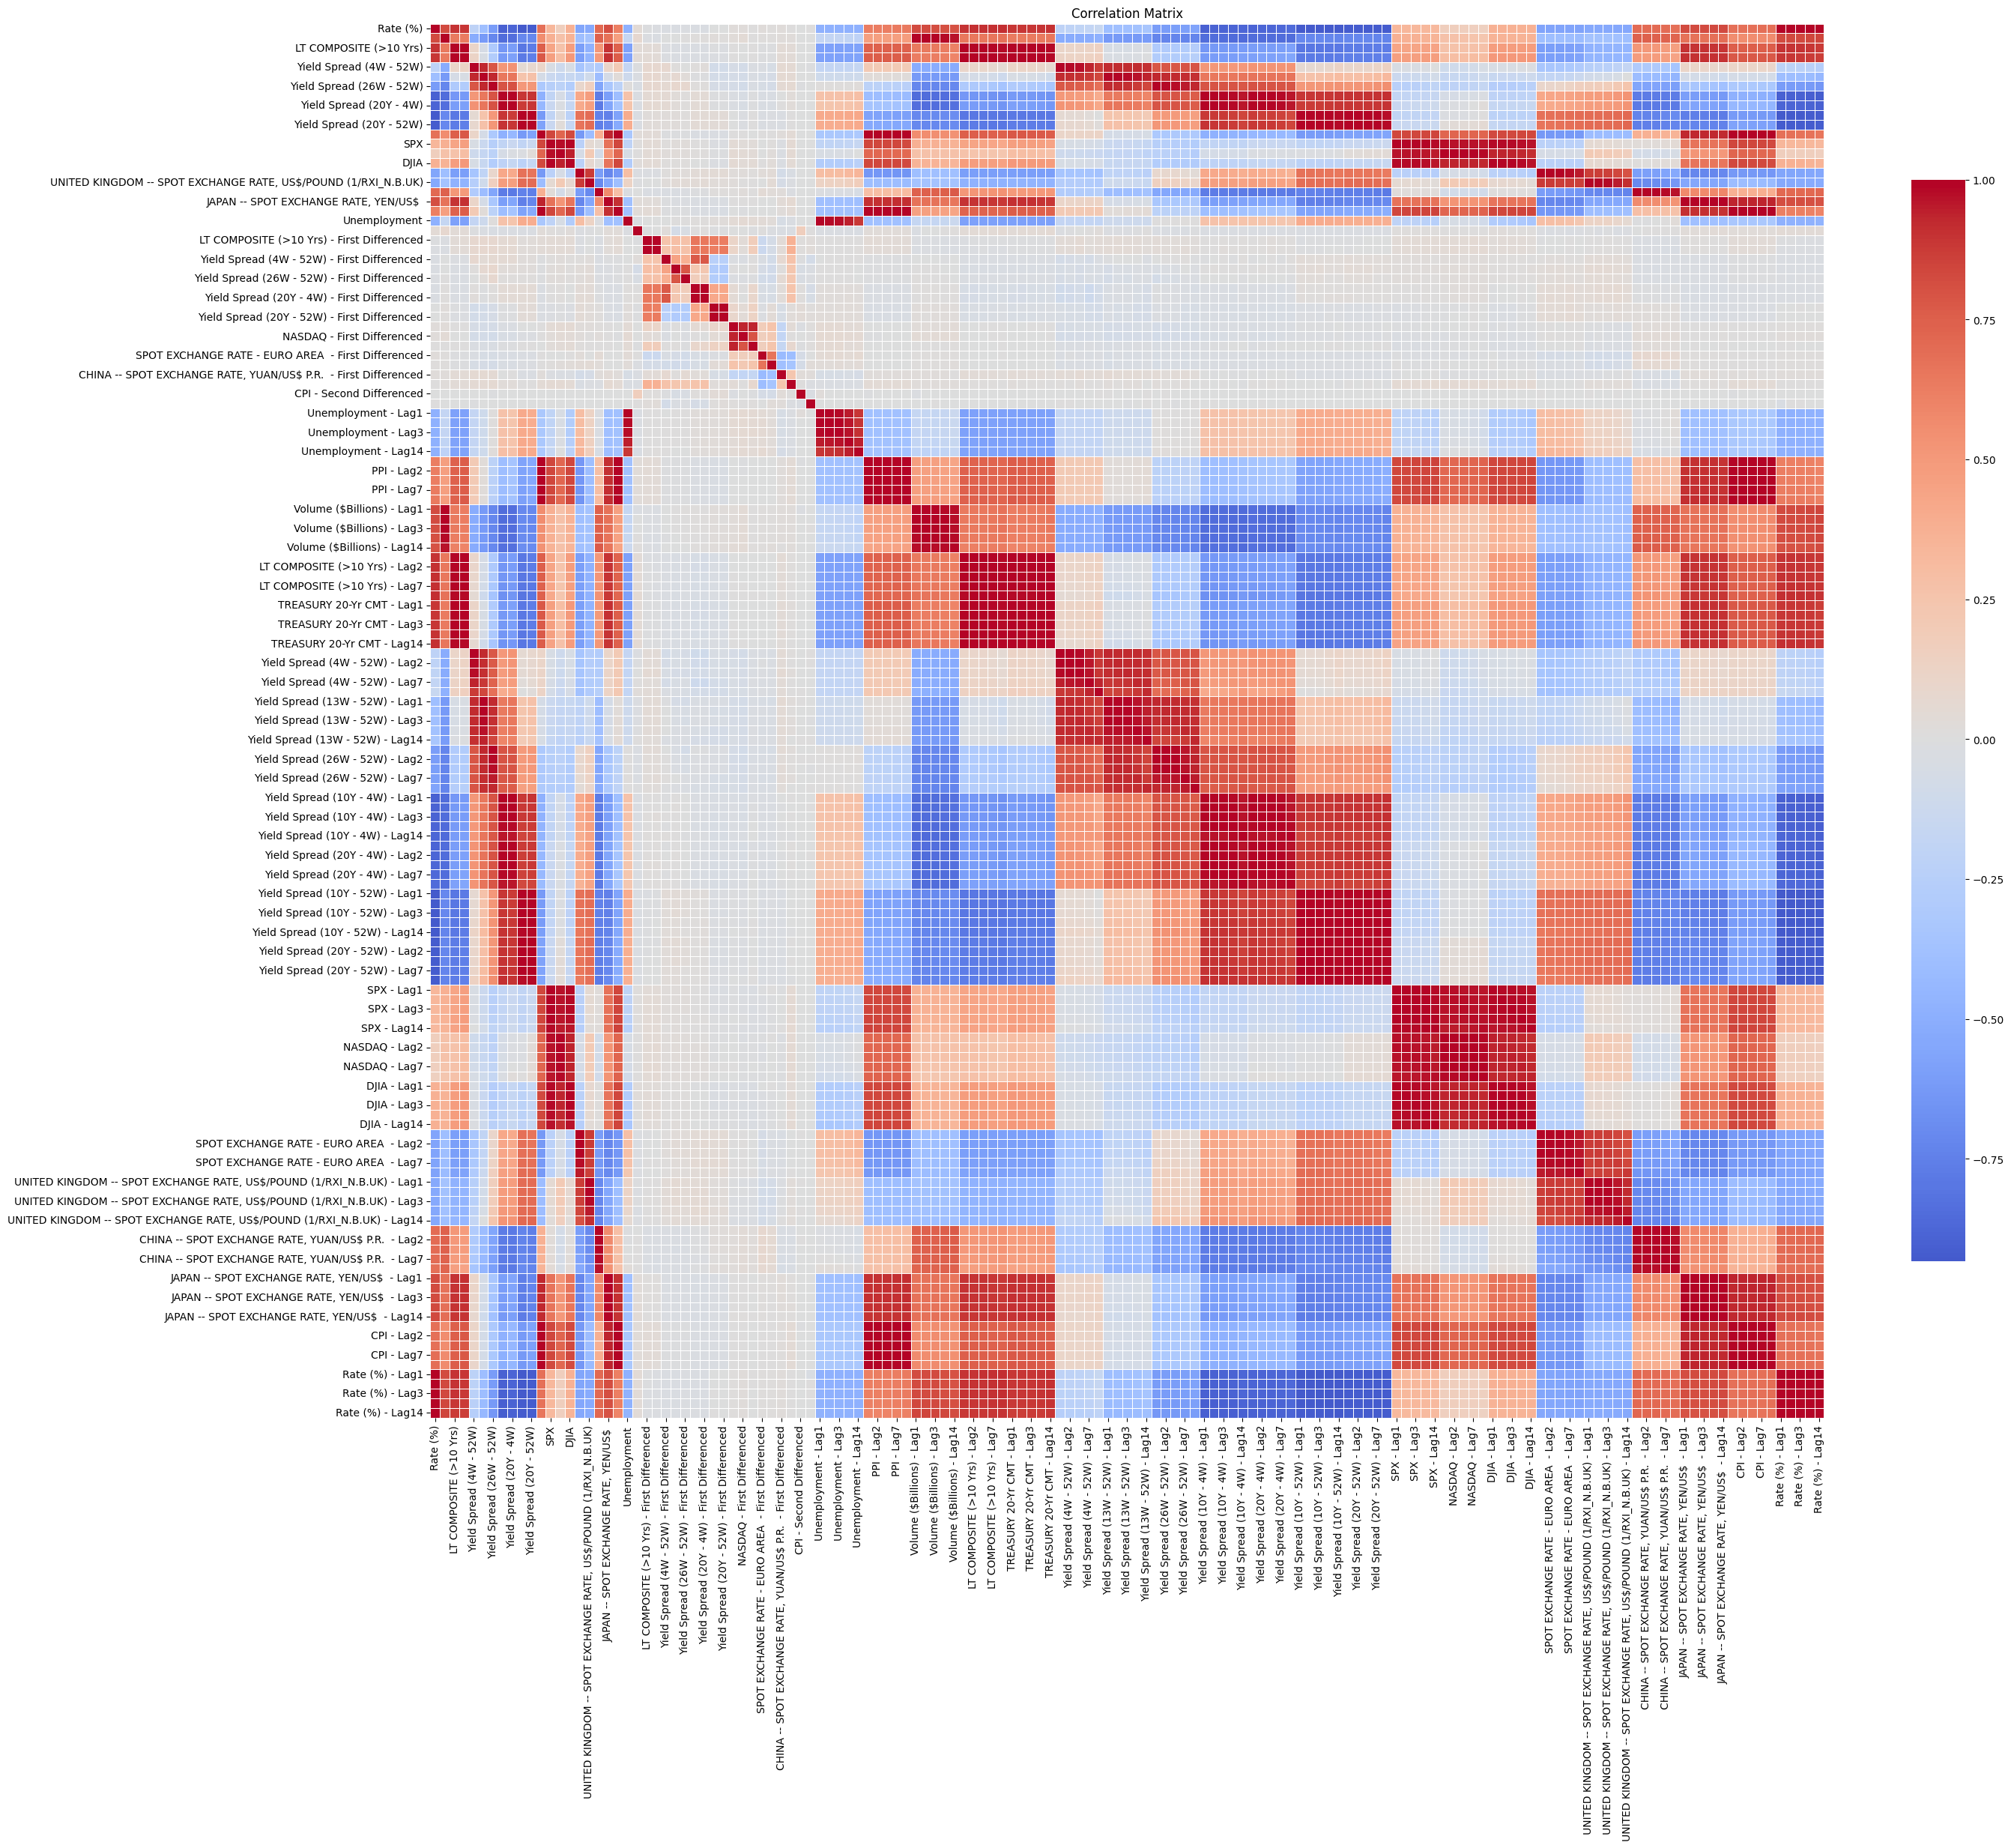

In [33]:
# Calculate the correlation matrix
correlation_matrix = df_prepared.corr()

# Plot the heatmap
plt.figure(figsize=(30, 25)) #14,12
sns.heatmap(correlation_matrix, annot=False, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .75})
plt.title('Correlation Matrix')
plt.show()

In [34]:
df_prepared_drop = df_prepared.copy()

df_prepared_drop = df_prepared.drop(columns=['Volume ($Billions)', 'LT COMPOSITE (>10 Yrs)',
                                             'TREASURY 20-Yr CMT', 'Yield Spread (4W - 52W)', 'Yield Spread (13W - 52W)',
                                             'Yield Spread (26W - 52W)', 'Yield Spread (10Y - 4W)', 'Yield Spread (20Y - 4W)',
                                             'Yield Spread (10Y - 52W)', 'Yield Spread (20Y - 52W)', 'CPI', 'SPX', 'NASDAQ',
                                             'DJIA', 'SPOT EXCHANGE RATE - EURO AREA ', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)',
                                             'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ', 'PPI', 'Unemployment'])

df_prepared_drop = df_prepared_drop.drop(columns=[
    # 'Rate (%)',
    # 'Rate (%) - Lag1',
    # 'Rate (%) - Lag2',
    # 'Rate (%) - Lag3',
    # 'Rate (%) - Lag7',
    'Rate (%) - Lag14',
    'Rate (%) - Second Differenced'
])

df_prepared_nona = df_prepared_drop.dropna()

## Training

In [35]:
# Split into train and test

train = df_prepared_nona[:'2022-12-31']
test = df_prepared_nona['2023-01-01':]

# Split into X & y

# y_train = train['Rate (%) - Second Differenced']
# X_train = train.drop(columns=['Rate (%) - Second Differenced'])
# y_test = test['Rate (%) - Second Differenced']
# X_test = test.drop(columns=['Rate (%) - Second Differenced'])

y_train = train['Rate (%)']
X_train = train.drop(columns=['Rate (%)'])
y_test = test['Rate (%)']
X_test = test.drop(columns=['Rate (%)'])


# Scaling values

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# model definition

model = SARIMAX(y_train, exog= X_train_scaled, order= (1,1,2), seasonal_order= (2,1,1,6)) # order was (1,1,1) seasonal_order was (0,0,0,0)
# (p, d, q) = (1,1,2) so dependent is differenced 1 (d) time, dependent lag 1 (p), error lag 2 (q)
# (P, D, Q, s) = (2,1,1,6) seasonal differencing 1 (D) time on a period of 6 (s), seasonal lag 2 (P), moving average 1 (Q)

model_fit = model.fit(disp=False)
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                            Rate (%)   No. Observations:                 1167
Model:             SARIMAX(1, 1, 2)x(2, 1, [1], 6)   Log Likelihood                 810.956
Date:                             Fri, 16 Aug 2024   AIC                          -1363.912
Time:                                     01:08:48   BIC                           -711.665
Sample:                                          0   HQIC                         -1117.805
                                            - 1167                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0538      0.055      0.975      0.330      -0.054       0.162
x2             0.0934      

## Testing

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


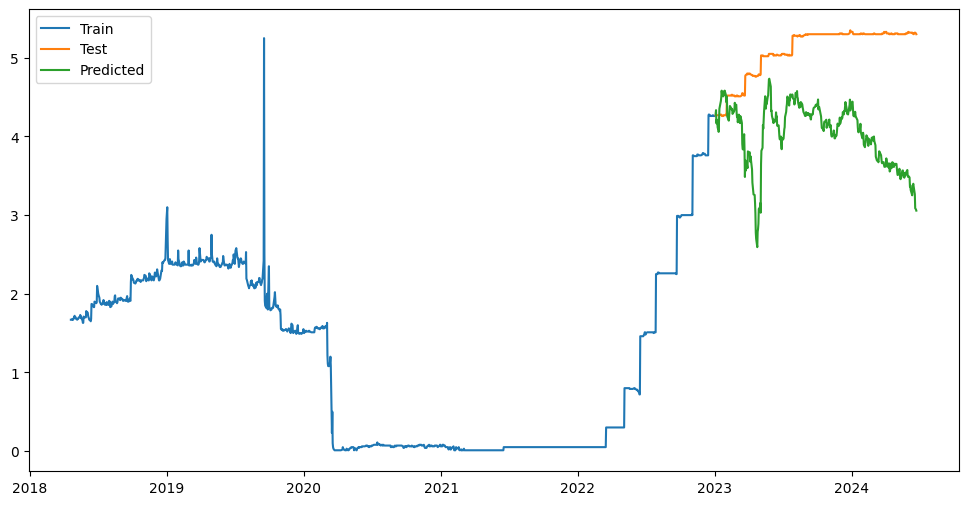

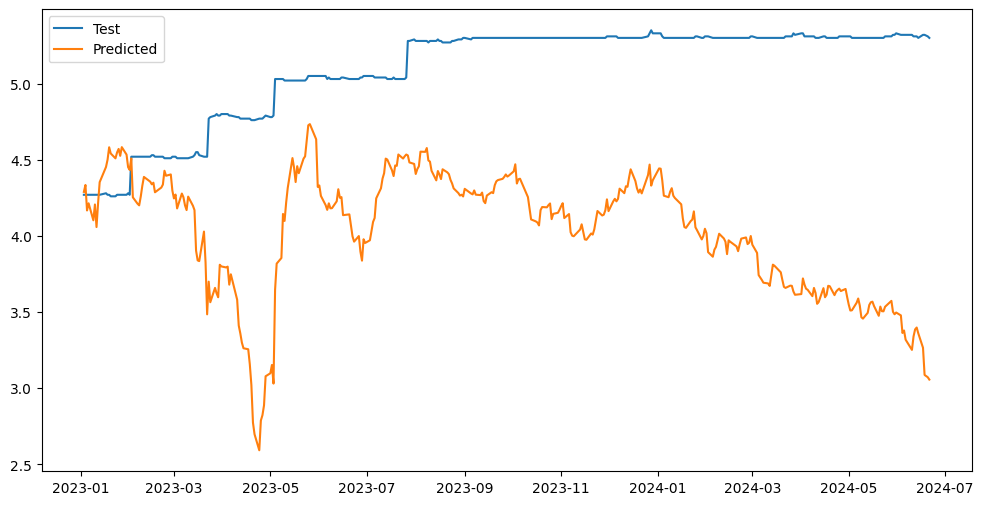

Mean Squared Error: 1.4295
Mean Absolute Error: 1.0794
R2 Score: -12.7064
Root Mean Squared Error: 1.1956
Adjusted R-squared: -19.5595


In [36]:
# Predict using the test set
y_pred = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test_scaled)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

print("\n\n")

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rsquare = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
n = len(y_test) # number of rows/observations
k = len(X_test_scaled[0]) # number of independent variables/features
arsquare = adjusted_r_squared(rsquare, n, k)

# Print the evaluation metrics
print(f'Mean Squared Error: {round(mse,4)}')
print(f'Mean Absolute Error: {round(mae,4)}')
print(f'R2 Score: {round(rsquare,4)}')
print(f'Root Mean Squared Error: {round(rmse,4)}')
print(f'Adjusted R-squared: {round(arsquare,4)}')

# Model 5: SARIMAX Model with VIF Feature Selection

## Re-introducing V2 Feature Set as V5

In [37]:
df_model_v5 = df_merged8.copy()
df_model_v5 = df_model_v5.drop(columns=[ 'Rate Type','1st Percentile (%)', '25th Percentile (%)', '75th Percentile (%)', '99th Percentile (%)'])

# Set the 'Date' column as the index
df_model_v5.set_index('Date', inplace=True)
df_model_v5 = df_model_v5.sort_index(ascending=True)
df_model_v5

# Replace 'ND' with NaN and fill with a method or drop rows
df_model_v5.replace('ND', np.nan, inplace=True)

print("NaN values in original features dataframe before dropping:")
print(df_model_v5.isna().sum())

# Drop rows with NaN values in the dataframe
df_model_v5.dropna(inplace=True)

cols = ['SPOT EXCHANGE RATE - EURO AREA ', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)', 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ']
df_model_v5[cols] = df_model_v5[cols].astype(float)

# Re-check for any remaining NaN values
print("\n\nNaN values in original features dataframe after dropping:")
print(df_model_v5.isna().sum())

NaN values in original features dataframe before dropping:
Rate (%)                                                          0
Volume ($Billions)                                                0
4 WEEKS COUPON EQUIVALENT                                         0
13 WEEKS COUPON EQUIVALENT                                        0
26 WEEKS COUPON EQUIVALENT                                        0
52 WEEKS COUPON EQUIVALENT                                        0
LT COMPOSITE (>10 Yrs)                                            0
TREASURY 20-Yr CMT                                                0
Yield Spread (4W - 52W)                                           0
Yield Spread (13W - 52W)                                          0
Yield Spread (26W - 52W)                                          0
Yield Spread (10Y - 4W)                                           0
Yield Spread (20Y - 4W)                                           0
Yield Spread (10Y - 52W)                                 

## Creating Lag & Difference Features

In [38]:
# Define a function to create lag features
def create_lag_features(df, lags, cols):
    for col in cols:
        for lag in lags:
            df[f'{col} - Lag{lag}'] = df[col].shift(lag)
    return df

# Define a function to create differenced features
def create_differenced_features(df, cols_for_first_diff, cols_for_second_diff):
    for col in cols_for_first_diff:
        df[f'{col} - First Differenced'] = df[col].diff()
    for col in cols_for_second_diff:
        df[f'{col} - Second Differenced'] = df[col].diff().diff()
    return df

# Apply differencing and lag feature creation to the DataFrame
def prepare_features(df, cols_for_first_diff, cols_for_second_diff):
    # Columns for which lag features will be created
    cols_for_lags = list(set(df.columns) - set(cols_for_first_diff + cols_for_second_diff))
    cols_for_lags += cols_for_first_diff + cols_for_second_diff  # Ensure all relevant columns are included

    # Create differenced features
    df = create_differenced_features(df, cols_for_first_diff, cols_for_second_diff)

    # Create lag features
    lags = [1, 2, 3, 7, 14]  # Adjust the list of lags based on your needs
    df = create_lag_features(df, lags, cols_for_lags)

    # Drop rows with NaN values created by differencing and lagging
    df.dropna(inplace=True)

    return df

# Specify the columns for first and second differencing
cols_for_first_diff = ['Volume ($Billions)','LT COMPOSITE (>10 Yrs)','TREASURY 20-Yr CMT',
                       'Yield Spread (4W - 52W)','Yield Spread (13W - 52W)','Yield Spread (26W - 52W)',
                       'Yield Spread (10Y - 4W)','Yield Spread (20Y - 4W)','Yield Spread (10Y - 52W)',
                       'Yield Spread (20Y - 52W)','SPX','NASDAQ','DJIA','SPOT EXCHANGE RATE - EURO AREA ',
                       'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)','CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ',
                       'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ', 'Unemployment']  # Replace with actual column names that need first differencing

cols_for_second_diff = ['4 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT',
                        '26 WEEKS COUPON EQUIVALENT', '52 WEEKS COUPON EQUIVALENT',
                        'CPI', 'Rate (%)', 'PPI']  # Replace with actual column names that need second differencing

# Prepare the features
df_prepared = prepare_features(df_model_v5.copy(), cols_for_first_diff, cols_for_second_diff)

print("Feature preparation (differencing and lag features) completed.\n\n")
df_prepared.head()

Feature preparation (differencing and lag features) completed.




<ipython-input-38-d8a630295671>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col} - Lag{lag}'] = df[col].shift(lag)
<ipython-input-38-d8a630295671>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col} - Lag{lag}'] = df[col].shift(lag)
<ipython-input-38-d8a630295671>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, 

,Rate (%),Volume ($Billions),4 WEEKS COUPON EQUIVALENT,13 WEEKS COUPON EQUIVALENT,26 WEEKS COUPON EQUIVALENT,52 WEEKS COUPON EQUIVALENT,LT COMPOSITE (>10 Yrs),TREASURY 20-Yr CMT,Yield Spread (4W - 52W),Yield Spread (13W - 52W),...,Rate (%) - Lag1,Rate (%) - Lag2,Rate (%) - Lag3,Rate (%) - Lag7,Rate (%) - Lag14,PPI - Lag1,PPI - Lag2,PPI - Lag3,PPI - Lag7,PPI - Lag14
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-20,1.67,340,1.64,1.81,2.01,2.20,3.09,3.04,0.56,0.39,...,1.67,1.69,1.70,1.70,1.77,115.5,115.5,115.5,115.5,115.5
2018-04-23,1.67,348,1.66,1.87,2.04,2.22,3.10,3.05,0.56,0.35,...,1.67,1.67,1.69,1.68,1.81,115.5,115.5,115.5,115.5,115.5
2018-04-24,1.68,339,1.70,1.87,2.05,2.25,3.12,3.08,0.55,0.38,...,1.67,1.67,1.67,1.68,1.70,115.5,115.5,115.5,115.5,115.5
2018-04-25,1.67,345,1.64,1.85,2.03,2.26,3.16,3.12,0.62,0.41,...,1.68,1.67,1.67,1.70,1.70,115.5,115.5,115.5,115.5,115.5
2018-04-26,1.67,333,1.61,1.82,2.02,2.25,3.13,3.08,0.64,0.43,...,1.67,1.68,1.67,1.70,1.70,115.5,115.5,115.5,115.5,115.5


## Use Correlation Matrix to create High Correlation Pairs

In [39]:
correlation_matrix = df_prepared.corr().abs()  # Use absolute values to consider both positive and negative correlations

# Create a mask to ignore the diagonal elements (self-correlations)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Apply the mask to the correlation matrix
correlation_matrix = correlation_matrix.mask(mask)

# Set a threshold for high correlations (e.g., 0.8)
high_correlation_threshold = 0.8

# Find pairs of features with correlation above the threshold
high_correlation_pairs = np.where(correlation_matrix > high_correlation_threshold)
high_correlation_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y])
                          for x, y in zip(*high_correlation_pairs) if x != y]

print("Highly correlated pairs of features:")
print(high_correlation_pairs)

Highly correlated pairs of features:
[('Volume ($Billions)', 'Rate (%)'), ('4 WEEKS COUPON EQUIVALENT', 'Rate (%)'), ('4 WEEKS COUPON EQUIVALENT', 'Volume ($Billions)'), ('13 WEEKS COUPON EQUIVALENT', 'Rate (%)'), ('13 WEEKS COUPON EQUIVALENT', '4 WEEKS COUPON EQUIVALENT'), ('26 WEEKS COUPON EQUIVALENT', 'Rate (%)'), ('26 WEEKS COUPON EQUIVALENT', '4 WEEKS COUPON EQUIVALENT'), ('26 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT'), ('52 WEEKS COUPON EQUIVALENT', 'Rate (%)'), ('52 WEEKS COUPON EQUIVALENT', '4 WEEKS COUPON EQUIVALENT'), ('52 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT'), ('52 WEEKS COUPON EQUIVALENT', '26 WEEKS COUPON EQUIVALENT'), ('LT COMPOSITE (>10 Yrs)', 'Rate (%)'), ('LT COMPOSITE (>10 Yrs)', '4 WEEKS COUPON EQUIVALENT'), ('LT COMPOSITE (>10 Yrs)', '13 WEEKS COUPON EQUIVALENT'), ('LT COMPOSITE (>10 Yrs)', '26 WEEKS COUPON EQUIVALENT'), ('LT COMPOSITE (>10 Yrs)', '52 WEEKS COUPON EQUIVALENT'), ('TREASURY 20-Yr CMT', 'Rate (%)'), ('TREASURY 20-Yr CMT',

## Use Variance Inflation Factor (VIF) to Eliminate Features

In [40]:
vif_df = df_prepared.copy()
# Set to keep track of features to drop
features_to_drop = set()

for pair in high_correlation_pairs:
    feature1, feature2 = pair

    # Drop the second feature of the pair
    features_to_drop.add(feature2)

# Drop the features from the DataFrame
df_reduced = vif_df.drop(columns=features_to_drop)

print("Features dropped due to high correlation:")
print(features_to_drop)

Features dropped due to high correlation:
{'Yield Spread (26W - 52W) - Lag1', '4 WEEKS COUPON EQUIVALENT - Lag1', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$  - Lag1', '4 WEEKS COUPON EQUIVALENT - Lag2', 'SPX - Lag7', '13 WEEKS COUPON EQUIVALENT', 'Yield Spread (20Y - 52W) - Lag1', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) - Lag1', 'Yield Spread (10Y - 52W) - Lag2', 'Yield Spread (10Y - 4W) - Lag1', 'DJIA - Lag2', 'PPI - Lag7', 'Yield Spread (10Y - 4W) - First Differenced', 'TREASURY 20-Yr CMT - Lag7', 'Yield Spread (4W - 52W) - Lag14', 'Yield Spread (20Y - 52W) - Lag3', '26 WEEKS COUPON EQUIVALENT - Lag7', 'SPOT EXCHANGE RATE - EURO AREA  - Lag3', 'Yield Spread (13W - 52W) - Lag2', '52 WEEKS COUPON EQUIVALENT - Lag2', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ', 'Unemployment - Lag1', 'SPOT EXCHANGE RATE - EURO AREA  - Lag2', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)', 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - Lag3', 'UNITED KINGDOM -- SPOT EXCHA

In [41]:
X = df_reduced.values
vif_df = pd.DataFrame()
vif_df["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif_df["Variable"] = df_reduced.columns

print("VIF values after handling multicollinearity:")
vif_df

VIF values after handling multicollinearity:


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,VIF,Variable
0,1.072388,Volume ($Billions) - First Differenced
1,7.863210,TREASURY 20-Yr CMT - First Differenced
2,inf,Yield Spread (4W - 52W) - First Differenced
3,8.006091,Yield Spread (13W - 52W) - First Differenced
4,7.529261,Yield Spread (26W - 52W) - First Differenced
5,inf,Yield Spread (20Y - 4W) - First Differenced
6,inf,Yield Spread (20Y - 52W) - First Differenced
7,2.762981,NASDAQ - First Differenced
8,2.925376,DJIA - First Differenced
9,2.046784,SPOT EXCHANGE RATE - EURO AREA - First Differ...


## High VIF columns to drop

In [42]:
columns_to_drop = [
 'TREASURY 20-Yr CMT - First Differenced',
 'Yield Spread (4W - 52W) - First Differenced',
 'Yield Spread (13W - 52W) - First Differenced',
 'Yield Spread (26W - 52W) - First Differenced',
 'Yield Spread (20Y - 4W) - First Differenced',
 'Yield Spread (20Y - 52W) - First Differenced',
 '26 WEEKS COUPON EQUIVALENT - Second Differenced',
 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) - Lag14',
 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - Lag14',
 'Unemployment - Lag14',
 'PPI - Lag14',
 'Rate (%) - Lag14']

df_prepared_nona = df_reduced.drop(columns=columns_to_drop)
df_prepared_nona['Rate (%)'] = df_model_v5['Rate (%)']

## Training

In [43]:
# Split into train and test

train = df_prepared_nona[:'2022-12-31']
test = df_prepared_nona['2023-01-01':]

# Split into X & y

# y_train = train['Rate (%) - Second Differenced']
# X_train = train.drop(columns=['Rate (%) - Second Differenced'])
# y_test = test['Rate (%) - Second Differenced']
# X_test = test.drop(columns=['Rate (%) - Second Differenced'])

y_train = train['Rate (%)']
X_train = train.drop(columns=['Rate (%)'])
y_test = test['Rate (%)']
X_test = test.drop(columns=['Rate (%)'])


# Scaling values

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# model definition

model = SARIMAX(y_train, exog= X_train_scaled, order= (2,1,1), seasonal_order= (1,1,2,4)) # order was (1,1,1) seasonal_order was (0,0,0,0)
# (p, d, q) = (1,1,2) so dependent is differenced 1 (d) time, dependent lag 1 (p), error lag 2 (q)
# (P, D, Q, s) = (2,1,1,6) seasonal differencing 1 (D) time on a period of 6 (s), seasonal lag 2 (P), moving average 1 (Q)

model_fit = model.fit(disp=False)
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                       SARIMAX Results                                        
Dep. Variable:                               Rate (%)   No. Observations:                 1167
Model:             SARIMAX(2, 1, 1)x(1, 1, [1, 2], 4)   Log Likelihood                1005.077
Date:                                Fri, 16 Aug 2024   AIC                          -1968.154
Time:                                        01:09:39   BIC                          -1861.938
Sample:                                             0   HQIC                         -1928.080
                                               - 1167                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0109      0.018     -0.601      0.548      -0.047       0.025
x2 

## Testing

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


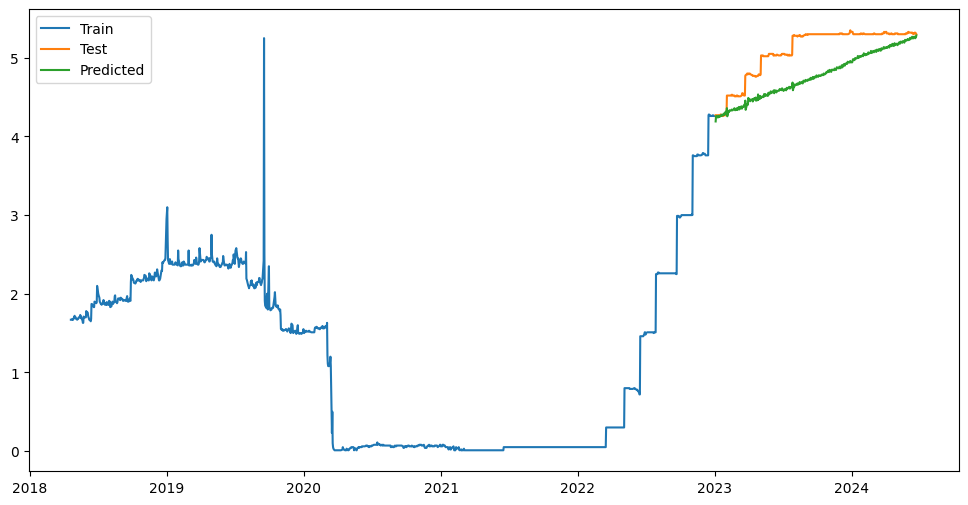

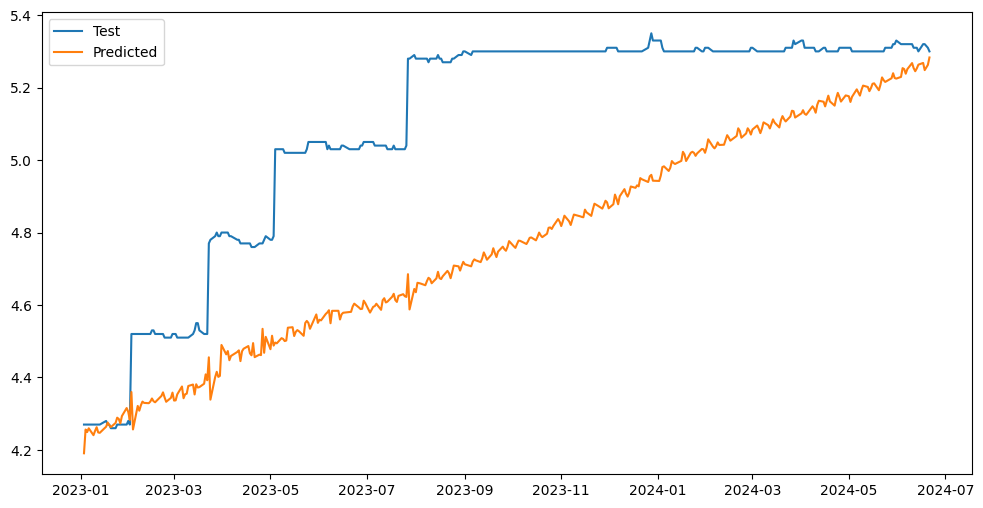

Mean Squared Error: 0.1347
Mean Absolute Error: 0.3214
R2 Score: -0.2919
Root Mean Squared Error: 0.3671
Adj R2 Score: -0.3433


In [44]:
# Predict using the test set
y_pred = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test_scaled)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

print("\n\n")

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rsquare = r2_score(y_test, y_pred)
n = len(y_test)
k = len(X_test_scaled[0])
rmse = np.sqrt(mse)
arsquare = 1 - (1 - rsquare) * ((n - 1) / (n - k - 1))

# Print the evaluation metrics
print(f'Mean Squared Error: {round(mse,4)}')
print(f'Mean Absolute Error: {round(mae,4)}')
print(f'R2 Score: {round(rsquare,4)}')
print(f'Root Mean Squared Error: {round(rmse,4)}')
print(f'Adj R2 Score: {round(arsquare,4)}')

# Model 6: SARIMAX Model with Additional Features and GARCH

## Add Fed Security Holdings

In [215]:
wsho_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/WSHOSHO.csv'
df = pd.read_csv(wsho_path)
df.rename(columns={'DATE': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

df_merged9 = pd.merge(df_merged8, df, on='Date', how='left')

df_merged9['WSHOSHO'] = df_merged9['WSHOSHO'].fillna(method = 'bfill')
df_merged9['WSHOSHO'] = df_merged9['WSHOSHO'].fillna(method= 'ffill')

<ipython-input-215-f7dbbca61a6a>:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged9['WSHOSHO'] = df_merged9['WSHOSHO'].fillna(method = 'bfill')
<ipython-input-215-f7dbbca61a6a>:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged9['WSHOSHO'] = df_merged9['WSHOSHO'].fillna(method= 'ffill')


,Date,Rate Type,Rate (%),1st Percentile (%),25th Percentile (%),75th Percentile (%),99th Percentile (%),Volume ($Billions),4 WEEKS COUPON EQUIVALENT,13 WEEKS COUPON EQUIVALENT,...,SPX,NASDAQ,DJIA,SPOT EXCHANGE RATE - EURO AREA,"UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)","CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.","JAPAN -- SPOT EXCHANGE RATE, YEN/US$",PPI,Unemployment,WSHOSHO
0,2024-06-21,BGCR,5.30,5.25,5.30,5.31,5.37,760,5.31,5.37,...,5464.62,17689.36,39150.33,1.0694,1.2645,7.2609,159.4500,144.402,4.1,6818650.0
1,2024-06-20,BGCR,5.31,5.25,5.31,5.31,5.36,767,5.31,5.38,...,5473.17,17721.59,39134.76,1.0708,1.2671,7.2604,158.7700,144.402,4.1,6818650.0
2,2024-06-18,BGCR,5.32,5.25,5.32,5.32,5.41,763,5.29,5.38,...,5487.03,17862.23,38834.86,1.0739,1.2699,7.2543,157.8100,144.402,4.1,6818650.0
3,2024-06-17,BGCR,5.32,5.26,5.31,5.32,5.42,772,5.34,5.39,...,5473.23,17857.02,38778.10,1.0723,1.2689,7.2561,157.8000,144.402,4.1,6818650.0
4,2024-06-14,BGCR,5.30,5.25,5.30,5.31,5.37,785,5.35,5.39,...,5431.60,17688.88,38589.16,1.0699,1.2685,7.2557,157.2800,144.402,4.1,6818650.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,2018-04-06,BGCR,1.70,1.60,1.70,1.70,1.83,352,1.67,1.73,...,2604.47,6915.11,23932.76,1.2274,1.4088,6.3045,107.0300,115.500,4.0,4171790.0
1552,2018-04-05,BGCR,1.70,1.60,1.70,1.70,1.85,349,1.66,1.72,...,2662.84,7076.55,24505.22,1.2230,1.3991,6.3045,107.4800,115.500,4.0,4171790.0
1553,2018-04-04,BGCR,1.70,1.57,1.70,1.70,1.81,348,1.68,1.71,...,2644.69,7042.11,24264.30,1.2292,1.4076,6.3045,106.5600,115.500,4.0,4171790.0
1554,2018-04-03,BGCR,1.81,1.50,1.80,1.82,1.97,344,1.70,1.75,...,2614.45,6941.28,24033.36,1.2261,1.4068,6.2881,106.4500,115.500,4.0,4171790.0


## Overnight Reverse Repo Facility (RRP)

In [217]:
rrpo_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/RRPONTSYD.csv'
df = pd.read_csv(rrpo_path)
df.rename(columns={'DATE': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

median_value = 162.8
df = df.replace('.', median_value)
df['RRPONTSYD'] = df['RRPONTSYD'].astype(float)

df_merged10 = pd.merge(df_merged9, df, on='Date', how='inner')

## Add Probability of rate hike/cut

In [218]:
wirp_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/Bloomberg data - WIRP AUG8 2024.csv'
df = pd.read_csv(wirp_path)
df.rename(columns={'Data': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

df_merged11 = pd.merge(df_merged10, df, on='Date', how='inner')

,Date,Rate Type,Rate (%),1st Percentile (%),25th Percentile (%),75th Percentile (%),99th Percentile (%),Volume ($Billions),4 WEEKS COUPON EQUIVALENT,13 WEEKS COUPON EQUIVALENT,...,DJIA,SPOT EXCHANGE RATE - EURO AREA,"UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)","CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.","JAPAN -- SPOT EXCHANGE RATE, YEN/US$",PPI,Unemployment,WSHOSHO,RRPONTSYD,#Hikes/Cuts
0,2024-06-21,BGCR,5.30,5.25,5.30,5.31,5.37,760,5.31,5.37,...,39150.33,1.0694,1.2645,7.2609,159.4500,144.402,4.1,6818650.0,421.040,-0.100
1,2024-06-20,BGCR,5.31,5.25,5.31,5.31,5.36,767,5.31,5.38,...,39134.76,1.0708,1.2671,7.2604,158.7700,144.402,4.1,6818650.0,388.841,-0.100
2,2024-06-18,BGCR,5.32,5.25,5.32,5.32,5.41,763,5.29,5.38,...,38834.86,1.0739,1.2699,7.2543,157.8100,144.402,4.1,6818650.0,375.542,-0.100
3,2024-06-17,BGCR,5.32,5.26,5.31,5.32,5.42,772,5.34,5.39,...,38778.10,1.0723,1.2689,7.2561,157.8000,144.402,4.1,6818650.0,333.429,-0.080
4,2024-06-14,BGCR,5.30,5.25,5.30,5.31,5.37,785,5.35,5.39,...,38589.16,1.0699,1.2685,7.2557,157.2800,144.402,4.1,6818650.0,386.885,-0.120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549,2018-04-06,BGCR,1.70,1.60,1.70,1.70,1.83,352,1.67,1.73,...,23932.76,1.2274,1.4088,6.3045,107.0300,115.500,4.0,4171790.0,4.895,0.001
1550,2018-04-05,BGCR,1.70,1.60,1.70,1.70,1.85,349,1.66,1.72,...,24505.22,1.2230,1.3991,6.3045,107.4800,115.500,4.0,4171790.0,4.645,0.012
1551,2018-04-04,BGCR,1.70,1.57,1.70,1.70,1.81,348,1.68,1.71,...,24264.30,1.2292,1.4076,6.3045,106.5600,115.500,4.0,4171790.0,4.570,0.001
1552,2018-04-03,BGCR,1.81,1.50,1.80,1.82,1.97,344,1.70,1.75,...,24033.36,1.2261,1.4068,6.2881,106.4500,115.500,4.0,4171790.0,8.695,0.023


## Final Feature Set

In [219]:
df_final = df_merged11.copy()
df_final = df_final.drop(columns=[ 'Rate Type','1st Percentile (%)', '25th Percentile (%)', '75th Percentile (%)', '99th Percentile (%)'])

df_final['Year'] = df_final['Date'].dt.year
df_final['Month'] = df_final['Date'].dt.month
df_final['Day'] = df_final['Date'].dt.day

# Set the 'Date' column as the index
df_final.set_index('Date', inplace=True)
df_final2 = df_final.sort_index(ascending=True)
df_final2

# Replace 'ND' with NaN and fill with a method or drop rows
df_final2.replace('ND', np.nan, inplace=True)

# Drop rows with NaN values in the dataframe
df_final2.dropna(inplace=True)

# Convert columns to float
cols = ['SPOT EXCHANGE RATE - EURO AREA ', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)', 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ']
df_final2[cols] = df_final2[cols].astype(float)

## Stationarity Checks

In [220]:
df_stationary = df_final2.copy()

# Function to check stationarity and apply differencing
def ensure_stationarity(series, name):
    try:
        print(f"\nChecking stationarity for {name}:\n")
        adf_test(series, title=name)
        print("\n")
        kpss_test(series, title=name)

        # Check stationarity after the first differencing if necessary
        if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
            print(f"\n{name} is not stationary. Applying first differencing.\n")
            series = series.diff().dropna()

            # Ensure no infinite or NaN values
            if np.isinf(series).any() or series.isna().any():
                series.replace([np.inf, -np.inf], np.nan, inplace=True)
                series.dropna(inplace=True)

            print(f"\nRe-checking stationarity for {name} after first differencing:\n")
            adf_test(series, title=f"{name} - First Differenced")
            print("\n")
            kpss_test(series, title=f"{name} - First Differenced")

            # Check stationarity after the second differencing if necessary
            if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
                print(f"\n{name} is still not stationary. Applying second differencing.\n")
                series = series.diff().dropna()

                # Ensure no infinite or NaN values
                if np.isinf(series).any() or series.isna().any():
                    series.replace([np.inf, -np.inf], np.nan, inplace=True)
                    series.dropna(inplace=True)

                print(f"\nRe-checking stationarity for {name} after second differencing:\n")
                adf_test(series, title=f"{name} - Second Differenced")
                print("\n")
                kpss_test(series, title=f"{name} - Second Differenced")
            else:
                print(f"\n{name} is stationary after first differencing.\n")
        else:
            print(f"{name} is already stationary.\n")
    except Exception as e:
        print(f"An error occurred while processing {name}: {e}")

    return series

# Apply the function to each explanatory variable
for col in df_stationary.columns:
    if col not in ['Rate (%)', 'Rate (%) - First Differenced', 'Rate (%) - Second Differenced']:
        df_stationary[col] = ensure_stationarity(df_final2[col], col)

# Now, let's ensure the 'Rate (%)' column is also stationary, applying the same procedure
df_stationary['Rate (%)'] = ensure_stationarity(df_final2['Rate (%)'], 'Rate (%)')

print("Stationarity check and differencing completed.")


Checking stationarity for Volume ($Billions):

===Augmented Dickey-Fuller Test: Volume ($Billions)===
ADF Test Statistic                0.769329
p-value                           0.991125
#Lags Used                       13.000000
Number of Observations Used    1532.000000
Critical Value (1%)              -3.434626
Critical Value (5%)              -2.863428
Critical Value (10%)             -2.567775
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Volume ($Billions)===
KPSS Test Statistic       2.145503
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary


<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



Volume ($Billions) is not stationary. Applying first differencing.


Re-checking stationarity for Volume ($Billions) after first differencing:

===Augmented Dickey-Fuller Test: Volume ($Billions) - First Differenced===
ADF Test Statistic            -1.262452e+01
p-value                        1.552087e-23
#Lags Used                     1.200000e+01
Number of Observations Used    1.532000e+03
Critical Value (1%)           -3.434626e+00
Critical Value (5%)           -2.863428e+00
Critical Value (10%)          -2.567775e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Volume ($Billions) - First Differenced===
KPSS Test Statistic       0.381160
p-value                   0.085276
#Lags Used               21.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothesis, time series i

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



4 WEEKS COUPON EQUIVALENT is not stationary. Applying first differencing.


Re-checking stationarity for 4 WEEKS COUPON EQUIVALENT after first differencing:

===Augmented Dickey-Fuller Test: 4 WEEKS COUPON EQUIVALENT - First Differenced===
ADF Test Statistic            -7.197427e+00
p-value                        2.414168e-10
#Lags Used                     2.400000e+01
Number of Observations Used    1.520000e+03
Critical Value (1%)           -3.434659e+00
Critical Value (5%)           -2.863443e+00
Critical Value (10%)          -2.567783e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: 4 WEEKS COUPON EQUIVALENT - First Differenced===
KPSS Test Statistic       0.596015
p-value                   0.022999
#Lags Used               21.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the 

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: 13 WEEKS COUPON EQUIVALENT===
ADF Test Statistic                0.061945
p-value                           0.963365
#Lags Used                       22.000000
Number of Observations Used    1523.000000
Critical Value (1%)              -3.434651
Critical Value (5%)              -2.863440
Critical Value (10%)             -2.567781
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: 13 WEEKS COUPON EQUIVALENT===
KPSS Test Statistic       2.88404
p-value                   0.01000
#Lags Used               25.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary


<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



13 WEEKS COUPON EQUIVALENT is not stationary. Applying first differencing.


Re-checking stationarity for 13 WEEKS COUPON EQUIVALENT after first differencing:

===Augmented Dickey-Fuller Test: 13 WEEKS COUPON EQUIVALENT - First Differenced===
ADF Test Statistic            -5.989547e+00
p-value                        1.758987e-07
#Lags Used                     2.100000e+01
Number of Observations Used    1.523000e+03
Critical Value (1%)           -3.434651e+00
Critical Value (5%)           -2.863440e+00
Critical Value (10%)          -2.567781e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: 13 WEEKS COUPON EQUIVALENT - First Differenced===
KPSS Test Statistic       0.95965
p-value                   0.01000
#Lags Used               22.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
Strong evidence against the nul

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-220-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:




Re-checking stationarity for 13 WEEKS COUPON EQUIVALENT after second differencing:

===Augmented Dickey-Fuller Test: 13 WEEKS COUPON EQUIVALENT - Second Differenced===
ADF Test Statistic            -1.319863e+01
p-value                        1.106107e-24
#Lags Used                     2.200000e+01
Number of Observations Used    1.521000e+03
Critical Value (1%)           -3.434657e+00
Critical Value (5%)           -2.863442e+00
Critical Value (10%)          -2.567783e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: 13 WEEKS COUPON EQUIVALENT - Second Differenced===
KPSS Test Statistic       0.01381
p-value                   0.10000
#Lags Used               28.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
Weak evidence against the null hypothesis, time series is stationary

Checking stationarity for 26 WEEKS

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: 26 WEEKS COUPON EQUIVALENT===
ADF Test Statistic               -0.076784
p-value                           0.951702
#Lags Used                       20.000000
Number of Observations Used    1525.000000
Critical Value (1%)              -3.434645
Critical Value (5%)              -2.863437
Critical Value (10%)             -2.567780
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: 26 WEEKS COUPON EQUIVALENT===
KPSS Test Statistic       2.956828
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

26 WEEKS COUPON EQUIVALENT is not stationary. Applying first differencing.


Re-checking stationarity for 26 WEEKS COUPON EQUIVALENT after first

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-220-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:


===Augmented Dickey-Fuller Test: 26 WEEKS COUPON EQUIVALENT - Second Differenced===
ADF Test Statistic            -1.521273e+01
p-value                        5.625099e-28
#Lags Used                     1.800000e+01
Number of Observations Used    1.525000e+03
Critical Value (1%)           -3.434645e+00
Critical Value (5%)           -2.863437e+00
Critical Value (10%)          -2.567780e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: 26 WEEKS COUPON EQUIVALENT - Second Differenced===
KPSS Test Statistic       0.006263
p-value                   0.100000
#Lags Used               17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothesis, time series is stationary

Checking stationarity for 52 WEEKS COUPON EQUIVALENT:

===Augmented Dickey-Fuller Test: 52 WEEKS COUPON EQUIVALEN

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



52 WEEKS COUPON EQUIVALENT is not stationary. Applying first differencing.


Re-checking stationarity for 52 WEEKS COUPON EQUIVALENT after first differencing:

===Augmented Dickey-Fuller Test: 52 WEEKS COUPON EQUIVALENT - First Differenced===
ADF Test Statistic            -6.320991e+00
p-value                        3.066545e-08
#Lags Used                     2.100000e+01
Number of Observations Used    1.523000e+03
Critical Value (1%)           -3.434651e+00
Critical Value (5%)           -2.863440e+00
Critical Value (10%)          -2.567781e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: 52 WEEKS COUPON EQUIVALENT - First Differenced===
KPSS Test Statistic      1.035431
p-value                  0.010000
#Lags Used               8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Strong evidence against the nul

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-220-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



52 WEEKS COUPON EQUIVALENT is still not stationary. Applying second differencing.


Re-checking stationarity for 52 WEEKS COUPON EQUIVALENT after second differencing:

===Augmented Dickey-Fuller Test: 52 WEEKS COUPON EQUIVALENT - Second Differenced===
ADF Test Statistic            -1.477315e+01
p-value                        2.305807e-27
#Lags Used                     2.000000e+01
Number of Observations Used    1.523000e+03
Critical Value (1%)           -3.434651e+00
Critical Value (5%)           -2.863440e+00
Critical Value (10%)          -2.567781e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: 52 WEEKS COUPON EQUIVALENT - Second Differenced===
KPSS Test Statistic       0.015698
p-value                   0.100000
#Lags Used               49.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence 

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: LT COMPOSITE (>10 Yrs)===
ADF Test Statistic               -0.361771
p-value                           0.916289
#Lags Used                        2.000000
Number of Observations Used    1543.000000
Critical Value (1%)              -3.434595
Critical Value (5%)              -2.863415
Critical Value (10%)             -2.567768
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: LT COMPOSITE (>10 Yrs)===
KPSS Test Statistic       3.093718
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

LT COMPOSITE (>10 Yrs) is not stationary. Applying first differencing.


Re-checking stationarity for LT COMPOSITE (>10 Yrs) after first differencing:



<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: LT COMPOSITE (>10 Yrs) - First Differenced===
ADF Test Statistic              -29.730934
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1543.000000
Critical Value (1%)              -3.434595
Critical Value (5%)              -2.863415
Critical Value (10%)             -2.567768
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: LT COMPOSITE (>10 Yrs) - First Differenced===
KPSS Test Statistic      0.305433
p-value                  0.100000
#Lags Used               0.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series is stationary

LT COMPOSITE (>10 Yrs) is stationary after first differencing.


Checking stationarity for TREASURY 20-Yr CMT:



<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-220-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:


===Augmented Dickey-Fuller Test: TREASURY 20-Yr CMT===
ADF Test Statistic               -0.303150
p-value                           0.925057
#Lags Used                        2.000000
Number of Observations Used    1543.000000
Critical Value (1%)              -3.434595
Critical Value (5%)              -2.863415
Critical Value (10%)             -2.567768
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: TREASURY 20-Yr CMT===
KPSS Test Statistic       3.248744
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary


<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



TREASURY 20-Yr CMT is not stationary. Applying first differencing.


Re-checking stationarity for TREASURY 20-Yr CMT after first differencing:

===Augmented Dickey-Fuller Test: TREASURY 20-Yr CMT - First Differenced===
ADF Test Statistic              -29.814525
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1543.000000
Critical Value (1%)              -3.434595
Critical Value (5%)              -2.863415
Critical Value (10%)             -2.567768
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: TREASURY 20-Yr CMT - First Differenced===
KPSS Test Statistic      0.320226
p-value                  0.100000
#Lags Used               1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series is stationary


<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-220-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



TREASURY 20-Yr CMT is stationary after first differencing.


Checking stationarity for Yield Spread (4W - 52W):

===Augmented Dickey-Fuller Test: Yield Spread (4W - 52W)===
ADF Test Statistic               -1.760983
p-value                           0.399997
#Lags Used                       23.000000
Number of Observations Used    1522.000000
Critical Value (1%)              -3.434654
Critical Value (5%)              -2.863441
Critical Value (10%)             -2.567782
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Yield Spread (4W - 52W)===
KPSS Test Statistic       0.552538
p-value                   0.029834
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Yield Spread (4W - 52W) is not stati

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-220-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



Yield Spread (4W - 52W) is stationary after first differencing.


Checking stationarity for Yield Spread (13W - 52W):

===Augmented Dickey-Fuller Test: Yield Spread (13W - 52W)===
ADF Test Statistic               -1.764315
p-value                           0.398317
#Lags Used                       23.000000
Number of Observations Used    1522.000000
Critical Value (1%)              -3.434654
Critical Value (5%)              -2.863441
Critical Value (10%)             -2.567782
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Yield Spread (13W - 52W)===
KPSS Test Statistic       0.552355
p-value                   0.029875
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Yield Spread (13W - 52W) is 

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-220-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:


===Augmented Dickey-Fuller Test: Yield Spread (26W - 52W)===
ADF Test Statistic               -1.796610
p-value                           0.382146
#Lags Used                       23.000000
Number of Observations Used    1522.000000
Critical Value (1%)              -3.434654
Critical Value (5%)              -2.863441
Critical Value (10%)             -2.567782
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Yield Spread (26W - 52W)===
KPSS Test Statistic       1.077618
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Yield Spread (26W - 52W) is not stationary. Applying first differencing.


Re-checking stationarity for Yield Spread (26W - 52W) after first differe

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: Yield Spread (26W - 52W) - First Differenced===
ADF Test Statistic            -8.356732e+00
p-value                        2.895650e-13
#Lags Used                     2.200000e+01
Number of Observations Used    1.522000e+03
Critical Value (1%)           -3.434654e+00
Critical Value (5%)           -2.863441e+00
Critical Value (10%)          -2.567782e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Yield Spread (26W - 52W) - First Differenced===
KPSS Test Statistic       0.065076
p-value                   0.100000
#Lags Used               20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothesis, time series is stationary

Yield Spread (26W - 52W) is stationary after first differencing.


Checking stationarity for Yield Spread (10Y - 4W):



<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-220-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:


===Augmented Dickey-Fuller Test: Yield Spread (10Y - 4W)===
ADF Test Statistic               -0.952275
p-value                           0.770271
#Lags Used                       22.000000
Number of Observations Used    1523.000000
Critical Value (1%)              -3.434651
Critical Value (5%)              -2.863440
Critical Value (10%)             -2.567781
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Yield Spread (10Y - 4W)===
KPSS Test Statistic       1.746966
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Yield Spread (10Y - 4W) is not stationary. Applying first differencing.


Re-checking stationarity for Yield Spread (10Y - 4W) after first differencin

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: Yield Spread (10Y - 4W) - First Differenced===
ADF Test Statistic            -9.001523e+00
p-value                        6.478101e-15
#Lags Used                     2.100000e+01
Number of Observations Used    1.523000e+03
Critical Value (1%)           -3.434651e+00
Critical Value (5%)           -2.863440e+00
Critical Value (10%)          -2.567781e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Yield Spread (10Y - 4W) - First Differenced===
KPSS Test Statistic       0.133747
p-value                   0.100000
#Lags Used               17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothesis, time series is stationary

Yield Spread (10Y - 4W) is stationary after first differencing.


Checking stationarity for Yield Spread (20Y - 4W):

===

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-220-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: Yield Spread (20Y - 4W) - First Differenced===
ADF Test Statistic            -9.006860e+00
p-value                        6.277574e-15
#Lags Used                     2.100000e+01
Number of Observations Used    1.523000e+03
Critical Value (1%)           -3.434651e+00
Critical Value (5%)           -2.863440e+00
Critical Value (10%)          -2.567781e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Yield Spread (20Y - 4W) - First Differenced===
KPSS Test Statistic       0.139397
p-value                   0.100000
#Lags Used               17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothesis, time series is stationary

Yield Spread (20Y - 4W) is stationary after first differencing.


Checking stationarity for Yield Spread (10Y - 52W):

==

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-220-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: Yield Spread (10Y - 52W) - First Differenced===
ADF Test Statistic              -21.686716
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    1541.000000
Critical Value (1%)              -3.434601
Critical Value (5%)              -2.863417
Critical Value (10%)             -2.567769
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Yield Spread (10Y - 52W) - First Differenced===
KPSS Test Statistic       0.226301
p-value                   0.100000
#Lags Used               13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothesis, time series is stationary

Yield Spread (10Y - 52W) is stationary after first differencing.


Checking stationarity for Yield Spread (20Y - 52W):

===Aug

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-220-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



Yield Spread (20Y - 52W) is not stationary. Applying first differencing.


Re-checking stationarity for Yield Spread (20Y - 52W) after first differencing:

===Augmented Dickey-Fuller Test: Yield Spread (20Y - 52W) - First Differenced===
ADF Test Statistic              -21.750841
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    1541.000000
Critical Value (1%)              -3.434601
Critical Value (5%)              -2.863417
Critical Value (10%)             -2.567769
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Yield Spread (20Y - 52W) - First Differenced===
KPSS Test Statistic       0.240508
p-value                   0.100000
#Lags Used               14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothes

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-220-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: CPI===
ADF Test Statistic                0.621968
p-value                           0.988145
#Lags Used                       23.000000
Number of Observations Used    1522.000000
Critical Value (1%)              -3.434654
Critical Value (5%)              -2.863441
Critical Value (10%)             -2.567782
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: CPI===
KPSS Test Statistic       5.858555
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

CPI is not stationary. Applying first differencing.


Re-checking stationarity for CPI after first differencing:

===Augmented Dickey-Fuller Test: CPI - First Differenced===
ADF Test Statist

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2171: RuntimeWarning: divide by zero encountered in scalar divide
  s_hat = s1 / s0
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-220-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-29-1a6fba92cac3>:2: Interpolatio


SPX is stationary after first differencing.


Checking stationarity for NASDAQ:

===Augmented Dickey-Fuller Test: NASDAQ===
ADF Test Statistic               -0.460287
p-value                           0.899536
#Lags Used                        9.000000
Number of Observations Used    1536.000000
Critical Value (1%)              -3.434614
Critical Value (5%)              -2.863424
Critical Value (10%)             -2.567773
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: NASDAQ===
KPSS Test Statistic       4.369509
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

NASDAQ is not stationary. Applying first differencing.


Re-checking stationarity for NASDAQ after fir

<ipython-input-220-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



NASDAQ is stationary after first differencing.


Checking stationarity for DJIA:

===Augmented Dickey-Fuller Test: DJIA===
ADF Test Statistic               -1.213607
p-value                           0.667715
#Lags Used                        9.000000
Number of Observations Used    1536.000000
Critical Value (1%)              -3.434614
Critical Value (5%)              -2.863424
Critical Value (10%)             -2.567773
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: DJIA===
KPSS Test Statistic       4.88821
p-value                   0.01000
#Lags Used               25.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

DJIA is not stationary. Applying first differencing.


Re-checking stationarity for DJIA after first differencin

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-220-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: SPOT EXCHANGE RATE - EURO AREA  - First Differenced===
ADF Test Statistic            -1.738202e+01
p-value                        5.066447e-30
#Lags Used                     5.000000e+00
Number of Observations Used    1.539000e+03
Critical Value (1%)           -3.434606e+00
Critical Value (5%)           -2.863420e+00
Critical Value (10%)          -2.567771e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: SPOT EXCHANGE RATE - EURO AREA  - First Differenced===
KPSS Test Statistic      0.087842
p-value                  0.100000
#Lags Used               3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series is stationary

SPOT EXCHANGE RATE - EURO AREA  is stationary after first differencing.


Checking stationarity for UNITED KINGD

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-220-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) - First Differenced===
ADF Test Statistic            -1.242900e+01
p-value                        3.979259e-23
#Lags Used                     1.000000e+01
Number of Observations Used    1.534000e+03
Critical Value (1%)           -3.434620e+00
Critical Value (5%)           -2.863426e+00
Critical Value (10%)          -2.567774e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) - First Differenced===
KPSS Test Statistic      0.073366
p-value                  0.100000
#Lags Used               5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series is stationary

UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-220-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - First Differenced===
ADF Test Statistic            -1.823553e+01
p-value                        2.361667e-30
#Lags Used                     3.000000e+00
Number of Observations Used    1.541000e+03
Critical Value (1%)           -3.434601e+00
Critical Value (5%)           -2.863417e+00
Critical Value (10%)          -2.567769e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - First Differenced===
KPSS Test Statistic      0.183258
p-value                  0.100000
#Lags Used               9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series is stationary

CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  is stationary after first differencing.


Ch

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-220-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



JAPAN -- SPOT EXCHANGE RATE, YEN/US$  is not stationary. Applying first differencing.


Re-checking stationarity for JAPAN -- SPOT EXCHANGE RATE, YEN/US$  after first differencing:

===Augmented Dickey-Fuller Test: JAPAN -- SPOT EXCHANGE RATE, YEN/US$  - First Differenced===
ADF Test Statistic              -24.428306
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    1542.000000
Critical Value (1%)              -3.434598
Critical Value (5%)              -2.863416
Critical Value (10%)             -2.567769
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: JAPAN -- SPOT EXCHANGE RATE, YEN/US$  - First Differenced===
KPSS Test Statistic      0.317456
p-value                  0.100000
#Lags Used               3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.7

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-220-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



PPI is not stationary. Applying first differencing.


Re-checking stationarity for PPI after first differencing:

===Augmented Dickey-Fuller Test: PPI - First Differenced===
ADF Test Statistic               -5.112369
p-value                           0.000013
#Lags Used                       22.000000
Number of Observations Used    1522.000000
Critical Value (1%)              -3.434654
Critical Value (5%)              -2.863441
Critical Value (10%)             -2.567782
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: PPI - First Differenced===
KPSS Test Statistic      0.521786
p-value                  0.036760
#Lags Used               8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

PPI is still not stationary. Appl

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: Unemployment - First Differenced===
ADF Test Statistic              -39.268310
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1544.000000
Critical Value (1%)              -3.434592
Critical Value (5%)              -2.863414
Critical Value (10%)             -2.567768
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Unemployment - First Differenced===
KPSS Test Statistic      0.041382
p-value                  0.100000
#Lags Used               0.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series is stationary

Unemployment is stationary after first differencing.


Checking stationarity for WSHOSHO:



<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-220-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:


===Augmented Dickey-Fuller Test: WSHOSHO===
ADF Test Statistic               -1.328627
p-value                           0.615976
#Lags Used                       23.000000
Number of Observations Used    1522.000000
Critical Value (1%)              -3.434654
Critical Value (5%)              -2.863441
Critical Value (10%)             -2.567782
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: WSHOSHO===
KPSS Test Statistic       4.80594
p-value                   0.01000
#Lags Used               25.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

WSHOSHO is not stationary. Applying first differencing.


Re-checking stationarity for WSHOSHO after first differencing:



<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: WSHOSHO - First Differenced===
ADF Test Statistic               -4.218008
p-value                           0.000614
#Lags Used                       24.000000
Number of Observations Used    1520.000000
Critical Value (1%)              -3.434659
Critical Value (5%)              -2.863443
Critical Value (10%)             -2.567783
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: WSHOSHO - First Differenced===
KPSS Test Statistic       0.810714
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

WSHOSHO is still not stationary. Applying second differencing.


Re-checking stationarity for WSHOSHO after second differencing:



<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-220-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:


===Augmented Dickey-Fuller Test: WSHOSHO - Second Differenced===
ADF Test Statistic            -1.151101e+01
p-value                        4.259996e-21
#Lags Used                     2.300000e+01
Number of Observations Used    1.520000e+03
Critical Value (1%)           -3.434659e+00
Critical Value (5%)           -2.863443e+00
Critical Value (10%)          -2.567783e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: WSHOSHO - Second Differenced===
KPSS Test Statistic       0.011519
p-value                   0.100000
#Lags Used               34.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothesis, time series is stationary

Checking stationarity for RRPONTSYD:

===Augmented Dickey-Fuller Test: RRPONTSYD===
ADF Test Statistic               -1.016896
p-value                 

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



RRPONTSYD is not stationary. Applying first differencing.


Re-checking stationarity for RRPONTSYD after first differencing:

===Augmented Dickey-Fuller Test: RRPONTSYD - First Differenced===
ADF Test Statistic            -5.873501e+00
p-value                        3.199232e-07
#Lags Used                     2.100000e+01
Number of Observations Used    1.523000e+03
Critical Value (1%)           -3.434651e+00
Critical Value (5%)           -2.863440e+00
Critical Value (10%)          -2.567781e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: RRPONTSYD - First Differenced===
KPSS Test Statistic       0.799425
p-value                   0.010000
#Lags Used               11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-station

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-220-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



RRPONTSYD is still not stationary. Applying second differencing.


Re-checking stationarity for RRPONTSYD after second differencing:

===Augmented Dickey-Fuller Test: RRPONTSYD - Second Differenced===
ADF Test Statistic            -1.520091e+01
p-value                        5.831453e-28
#Lags Used                     2.400000e+01
Number of Observations Used    1.519000e+03
Critical Value (1%)           -3.434662e+00
Critical Value (5%)           -2.863445e+00
Critical Value (10%)          -2.567784e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: RRPONTSYD - Second Differenced===
KPSS Test Statistic       0.033887
p-value                   0.100000
#Lags Used               76.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothesis, time series is stationary

Checking sta

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: #Hikes/Cuts===
ADF Test Statistic               -2.317720
p-value                           0.166316
#Lags Used                       12.000000
Number of Observations Used    1533.000000
Critical Value (1%)              -3.434623
Critical Value (5%)              -2.863427
Critical Value (10%)             -2.567775
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: #Hikes/Cuts===
KPSS Test Statistic       1.310173
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

#Hikes/Cuts is not stationary. Applying first differencing.


Re-checking stationarity for #Hikes/Cuts after first differencing:

===Augmented Dickey-Fuller Test: #Hikes/Cuts

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-220-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:


===Augmented Dickey-Fuller Test: Year===
ADF Test Statistic               -0.491208
p-value                           0.893721
#Lags Used                        0.000000
Number of Observations Used    1545.000000
Critical Value (1%)              -3.434590
Critical Value (5%)              -2.863413
Critical Value (10%)             -2.567767
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Year===
KPSS Test Statistic       5.911775
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Year is not stationary. Applying first differencing.


Re-checking stationarity for Year after first differencing:

===Augmented Dickey-Fuller Test: Year - First Differenced===
ADF Test St

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-220-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


Year is stationary after first differencing.


Checking stationarity for Month:

===Augmented Dickey-Fuller Test: Month===
ADF Test Statistic               -4.240234
p-value                           0.000563
#Lags Used                        0.000000
Number of Observations Used    1545.000000
Critical Value (1%)              -3.434590
Critical Value (5%)              -2.863413
Critical Value (10%)             -2.567767
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Month===
KPSS Test Statistic       0.049083
p-value                   0.100000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothesis, time series is stationary


<ipython-input-220-622013a18d5a>:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')


Month is already stationary.


Checking stationarity for Day:

===Augmented Dickey-Fuller Test: Day===
ADF Test Statistic            -8.544009e+00
p-value                        9.611921e-14
#Lags Used                     2.300000e+01
Number of Observations Used    1.522000e+03
Critical Value (1%)           -3.434654e+00
Critical Value (5%)           -2.863441e+00
Critical Value (10%)          -2.567782e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Day===
KPSS Test Statistic       0.0079
p-value                   0.1000
#Lags Used               14.0000
Critical Value (10%)      0.3470
Critical Value (5%)       0.4630
Critical Value (2.5%)     0.5740
Critical Value (1%)       0.7390
Weak evidence against the null hypothesis, time series is stationary


<ipython-input-220-622013a18d5a>:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


Day is already stationary.


Checking stationarity for Rate (%):

===Augmented Dickey-Fuller Test: Rate (%)===
ADF Test Statistic                0.507621
p-value                           0.985103
#Lags Used                        9.000000
Number of Observations Used    1536.000000
Critical Value (1%)              -3.434614
Critical Value (5%)              -2.863424
Critical Value (10%)             -2.567773
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Rate (%)===
KPSS Test Statistic       2.704747
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Rate (%) is not stationary. Applying first differencing.


Re-checking stationarity for Rate (%) after first diffe

<ipython-input-29-1a6fba92cac3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')


## Creating Lag & Difference Features

In [221]:
# Define a function to create lag features
def create_lag_features(df, lags, cols):
    for col in cols:
        for lag in lags:
            df[f'{col} - Lag{lag}'] = df[col].shift(lag)
    return df

# Define a function to create differenced features
def create_differenced_features(df, cols_for_first_diff, cols_for_second_diff):
    for col in cols_for_first_diff:
        df[f'{col} - First Differenced'] = df[col].diff()
    for col in cols_for_second_diff:
        df[f'{col} - Second Differenced'] = df[col].diff().diff()
    return df

# Apply differencing and lag feature creation to the DataFrame
def prepare_features(df, cols_for_first_diff, cols_for_second_diff):
    # Columns for which lag features will be created
    cols_for_lags = list(set(df.columns) - set(cols_for_first_diff + cols_for_second_diff))
    cols_for_lags += cols_for_first_diff + cols_for_second_diff  # Ensure all relevant columns are included

    # Create differenced features
    df = create_differenced_features(df, cols_for_first_diff, cols_for_second_diff)

    # Create lag features
    lags = [1, 2, 3, 7, 14]  # Adjust the list of lags based on your needs
    df = create_lag_features(df, lags, cols_for_lags)

    # Drop rows with NaN values created by differencing and lagging
    df.dropna(inplace=True)

    return df

# Specify the columns for first and second differencing
cols_for_first_diff = ['Volume ($Billions)','LT COMPOSITE (>10 Yrs)','TREASURY 20-Yr CMT',
                       'Yield Spread (4W - 52W)','Yield Spread (13W - 52W)','Yield Spread (26W - 52W)',
                       'Yield Spread (10Y - 4W)','Yield Spread (20Y - 4W)','Yield Spread (10Y - 52W)',
                       'Yield Spread (20Y - 52W)','SPX','NASDAQ','DJIA','SPOT EXCHANGE RATE - EURO AREA ',
                       'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)','CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ',
                       'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ', 'Unemployment', 'Year', '#Hikes/Cuts']  # Replace with actual column names that need first differencing

cols_for_second_diff = ['4 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT',
                        '26 WEEKS COUPON EQUIVALENT', '52 WEEKS COUPON EQUIVALENT',
                        'CPI', 'Rate (%)', 'PPI', 'RRPONTSYD', 'WSHOSHO']  # Replace with actual column names that need second differencing

# Prepare the features
df_prepared = prepare_features(df_final2.copy(), cols_for_first_diff, cols_for_second_diff)

print("Feature preparation (differencing and lag features) completed.\n\n")
df_prepared.head()

Feature preparation (differencing and lag features) completed.




<ipython-input-221-2b54e7a450c5>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col} - Lag{lag}'] = df[col].shift(lag)
<ipython-input-221-2b54e7a450c5>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col} - Lag{lag}'] = df[col].shift(lag)
<ipython-input-221-2b54e7a450c5>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fram

,Rate (%),Volume ($Billions),4 WEEKS COUPON EQUIVALENT,13 WEEKS COUPON EQUIVALENT,26 WEEKS COUPON EQUIVALENT,52 WEEKS COUPON EQUIVALENT,LT COMPOSITE (>10 Yrs),TREASURY 20-Yr CMT,Yield Spread (4W - 52W),Yield Spread (13W - 52W),...,RRPONTSYD - Lag1,RRPONTSYD - Lag2,RRPONTSYD - Lag3,RRPONTSYD - Lag7,RRPONTSYD - Lag14,WSHOSHO - Lag1,WSHOSHO - Lag2,WSHOSHO - Lag3,WSHOSHO - Lag7,WSHOSHO - Lag14
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-20,1.67,340,1.64,1.81,2.01,2.20,3.09,3.04,0.56,0.39,...,13.920,14.021,3.971,2.361,3.823,4173760.0,4173760.0,4171820.0,4171820.0,4171790.0
2018-04-23,1.67,348,1.66,1.87,2.04,2.22,3.10,3.05,0.56,0.35,...,12.020,13.920,14.021,4.120,8.695,4173760.0,4173760.0,4173760.0,4171820.0,4171790.0
2018-04-24,1.68,339,1.70,1.87,2.05,2.25,3.12,3.08,0.55,0.38,...,10.821,12.020,13.920,3.471,4.570,4173760.0,4173760.0,4173760.0,4171820.0,4171790.0
2018-04-25,1.67,345,1.64,1.85,2.03,2.26,3.16,3.12,0.62,0.41,...,9.532,10.821,12.020,3.372,4.645,4173760.0,4173760.0,4173760.0,4171820.0,4171790.0
2018-04-26,1.67,333,1.61,1.82,2.02,2.25,3.13,3.08,0.64,0.43,...,3.570,9.532,10.821,3.971,4.895,4162576.0,4173760.0,4173760.0,4171820.0,4171790.0


## Use Correlation Matrix to create High Correlation Pairs

In [222]:
correlation_matrix = df_prepared.corr().abs()  # Use absolute values to consider both positive and negative correlations

# Create a mask to ignore the diagonal elements (self-correlations)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Apply the mask to the correlation matrix
correlation_matrix = correlation_matrix.mask(mask)

# Set a threshold for high correlations (e.g., 0.8)
high_correlation_threshold = 0.8

# Find pairs of features with correlation above the threshold
high_correlation_pairs = np.where(correlation_matrix > high_correlation_threshold)
high_correlation_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y])
                          for x, y in zip(*high_correlation_pairs) if x != y]

print("Highly correlated pairs of features:")
print(high_correlation_pairs)

Highly correlated pairs of features:
[('Volume ($Billions)', 'Rate (%)'), ('4 WEEKS COUPON EQUIVALENT', 'Rate (%)'), ('4 WEEKS COUPON EQUIVALENT', 'Volume ($Billions)'), ('13 WEEKS COUPON EQUIVALENT', 'Rate (%)'), ('13 WEEKS COUPON EQUIVALENT', '4 WEEKS COUPON EQUIVALENT'), ('26 WEEKS COUPON EQUIVALENT', 'Rate (%)'), ('26 WEEKS COUPON EQUIVALENT', '4 WEEKS COUPON EQUIVALENT'), ('26 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT'), ('52 WEEKS COUPON EQUIVALENT', 'Rate (%)'), ('52 WEEKS COUPON EQUIVALENT', '4 WEEKS COUPON EQUIVALENT'), ('52 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT'), ('52 WEEKS COUPON EQUIVALENT', '26 WEEKS COUPON EQUIVALENT'), ('LT COMPOSITE (>10 Yrs)', 'Rate (%)'), ('LT COMPOSITE (>10 Yrs)', '4 WEEKS COUPON EQUIVALENT'), ('LT COMPOSITE (>10 Yrs)', '13 WEEKS COUPON EQUIVALENT'), ('LT COMPOSITE (>10 Yrs)', '26 WEEKS COUPON EQUIVALENT'), ('LT COMPOSITE (>10 Yrs)', '52 WEEKS COUPON EQUIVALENT'), ('TREASURY 20-Yr CMT', 'Rate (%)'), ('TREASURY 20-Yr CMT',

## Use Variance Inflation Factor (VIF) to Eliminate Features

In [223]:
vif_df = df_prepared.copy()
# Set to keep track of features to drop
features_to_drop = set()

for pair in high_correlation_pairs:
    feature1, feature2 = pair

    # Drop the second feature of the pair
    features_to_drop.add(feature2)

# Drop the features from the DataFrame
df_reduced = vif_df.drop(columns=features_to_drop)

print("Features dropped due to high correlation:")
print(features_to_drop)

Features dropped due to high correlation:
{'Yield Spread (26W - 52W) - Lag1', '4 WEEKS COUPON EQUIVALENT - Lag1', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$  - Lag1', '4 WEEKS COUPON EQUIVALENT - Lag2', 'SPX - Lag7', '13 WEEKS COUPON EQUIVALENT', 'Yield Spread (20Y - 52W) - Lag1', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) - Lag1', 'Month - Lag7', 'Yield Spread (10Y - 52W) - Lag2', 'Yield Spread (10Y - 4W) - Lag1', 'WSHOSHO', 'DJIA - Lag2', 'PPI - Lag7', 'Yield Spread (10Y - 4W) - First Differenced', 'TREASURY 20-Yr CMT - Lag7', 'Yield Spread (4W - 52W) - Lag14', 'Yield Spread (20Y - 52W) - Lag3', '26 WEEKS COUPON EQUIVALENT - Lag7', 'SPOT EXCHANGE RATE - EURO AREA  - Lag3', 'Yield Spread (13W - 52W) - Lag2', '52 WEEKS COUPON EQUIVALENT - Lag2', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ', 'Unemployment - Lag1', 'SPOT EXCHANGE RATE - EURO AREA  - Lag2', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)', 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - Lag3', 'U

In [224]:
X = df_reduced.values
vif_df = pd.DataFrame()
vif_df["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif_df["Variable"] = df_reduced.columns

print("VIF values after handling multicollinearity:")
vif_df

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF values after handling multicollinearity:


/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,VIF,Variable
0,13.848291,Day
1,1.215817,Volume ($Billions) - First Differenced
2,8.300921,TREASURY 20-Yr CMT - First Differenced
3,inf,Yield Spread (4W - 52W) - First Differenced
4,8.095193,Yield Spread (13W - 52W) - First Differenced
5,7.583458,Yield Spread (26W - 52W) - First Differenced
6,inf,Yield Spread (20Y - 4W) - First Differenced
7,inf,Yield Spread (20Y - 52W) - First Differenced
8,2.800662,NASDAQ - First Differenced
9,2.985874,DJIA - First Differenced


## High VIF columns to drop

In [225]:
columns_to_drop = [
 'Volume ($Billions) - First Differenced',
 'TREASURY 20-Yr CMT - First Differenced',
 'Yield Spread (26W - 52W) - First Differenced',
 'DJIA - First Differenced',
 'SPOT EXCHANGE RATE - EURO AREA  - First Differenced',
 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) - First Differenced',
 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - First Differenced',
 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$  - First Differenced',
 'Unemployment - First Differenced',
 'Year - First Differenced',
 '#Hikes/Cuts - First Differenced',
 '4 WEEKS COUPON EQUIVALENT - Second Differenced',
 '52 WEEKS COUPON EQUIVALENT - Second Differenced',
 'Rate (%) - Second Differenced',
 'PPI - Second Differenced',
 'RRPONTSYD - Second Differenced',
 'WSHOSHO - Second Differenced',
 'Yield Spread (26W - 52W) - Lag14',
 '#Hikes/Cuts - Lag14',]

df_prepared_nona = df_reduced.drop(columns=columns_to_drop)
df_prepared_nona['Rate (%)'] = df_final2['Rate (%)']

## Training

In [226]:
# Split into train and test

train = df_prepared_nona[:'2022-12-31']
test = df_prepared_nona['2023-01-01':]

# Split into X & y

# y_train = train['Rate (%) - Second Differenced']
# X_train = train.drop(columns=['Rate (%) - Second Differenced'])
# y_test = test['Rate (%) - Second Differenced']
# X_test = test.drop(columns=['Rate (%) - Second Differenced'])

y_train = train['Rate (%)']
X_train = train.drop(columns=['Rate (%)'])
y_test = test['Rate (%)']
X_test = test.drop(columns=['Rate (%)'])


# Scaling values

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# model definition

model = SARIMAX(y_train, exog= X_train_scaled, order= (0,0,1), seasonal_order= (1,0,0,12)) # order was (1,1,1) seasonal_order was (0,0,0,0)
# (p, d, q) = (1,1,2) so dependent is differenced 1 (d) time, dependent lag 1 (p), error lag 2 (q)
# (P, D, Q, s) = (2,1,1,6) seasonal differencing 1 (D) time on a period of 6 (s), seasonal lag 2 (P), moving average 1 (Q)

model_fit = model.fit(disp=False)
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                            Rate (%)   No. Observations:                 1165
Model:             SARIMAX(0, 0, 1)x(1, 0, [], 12)   Log Likelihood                 183.840
Date:                             Fri, 16 Aug 2024   AIC                           -323.680
Time:                                     03:47:07   BIC                           -212.349
Sample:                                          0   HQIC                          -281.681
                                            - 1165                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0165      0.039      0.428      0.668      -0.059       0.092
x2             0.9705      

## Testing

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


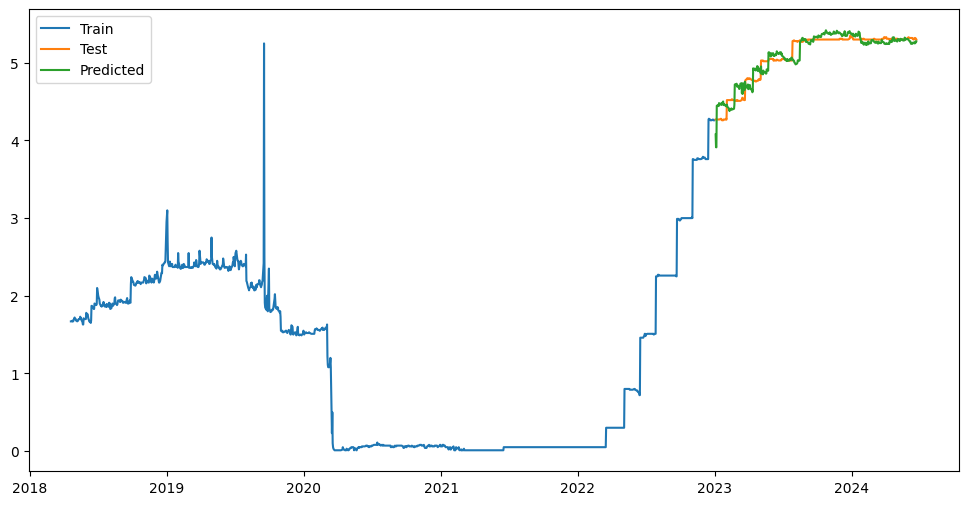

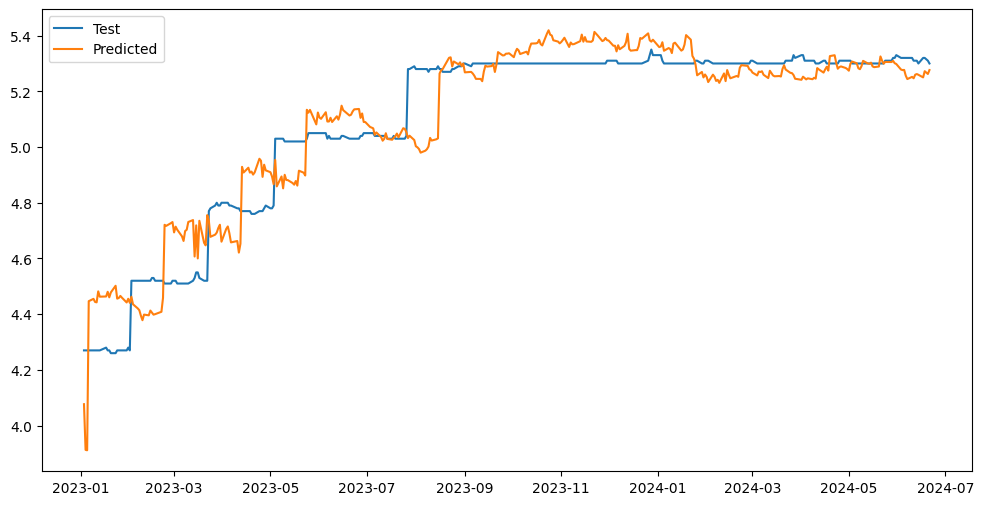

Mean Squared Error: 0.0118
Mean Absolute Error: 0.0831
R2 Score: 0.8871
Root Mean Squared Error: 0.1085
Adj R2 Score: 0.8809


In [227]:
# Predict using the test set
y_pred = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test_scaled)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

print("\n\n")

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rsquare = r2_score(y_test, y_pred)
n = len(y_test) # number of rows/observations
k = len(X_test_scaled[0]) # number of independent variables/features
rmse = np.sqrt(mse)
arsquare = 1 - (1 - rsquare) * ((n - 1) / (n - k - 1))

# Print the evaluation metrics
print(f'Mean Squared Error: {round(mse,4)}')
print(f'Mean Absolute Error: {round(mae,4)}')
print(f'R2 Score: {round(rsquare,4)}')
print(f'Root Mean Squared Error: {round(rmse,4)}')
print(f'Adj R2 Score: {round(arsquare,4)}')

## Integrating GARCH

In [228]:
! pip -q install arch

from arch import arch_model

In [230]:
residuals = model_fit.resid

garch_model = arch_model(residuals, vol='Garch', p=1, q=1)  # GARCH(1, 1) model
garch_result = garch_model.fit()

# Print summary
print(garch_result.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: -842.1493864598631
Optimization terminated successfully    (Exit mode 0)
            Current function value: -842.1493934975254
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                842.149
Distribution:                  Normal   AIC:                          -1676.30
Method:            Maximum Likelihood   BIC:                          -1656.06
                                        No. Observations:                 1165
Date:                Fri, Aug 16 2024   Df Residuals:                     1164
Time:                        03:51:52   Df Model:                            1
         

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04269. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [231]:
# Forecasting with SARIMAX
sarimax_forecast = model_fit.get_forecast(steps=len(y_test), exog=X_test_scaled)
sarimax_forecast_mean = pd.DataFrame(sarimax_forecast.predicted_mean)
sarimax_forecast_conf_int = sarimax_forecast.conf_int()

sarimax_forecast_mean.reset_index(inplace=True)
sarimax_forecast_mean = sarimax_forecast_mean.drop(columns=['index'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [232]:
# Forecasting volatility with GARCH
garch_forecast = garch_result.forecast(horizon=len(y_test))
garch_forecast_variance = garch_forecast.variance

# Preparing output for plotting
garch_forecast_variance.reset_index(inplace=True)
garch_forecast_variance = garch_forecast_variance.drop(columns=['Date'])
garch_forecast_variance['garch_forecast_variance'] = 'Garch Forecast Variance'
cols = garch_forecast_variance.columns.to_list()
cols.sort()
garch_forecast_variance = garch_forecast_variance[cols]
garch_forecast_variance = pd.DataFrame.transpose(garch_forecast_variance)
garch_forecast_variance.reset_index(inplace=True)
garch_forecast_variance.columns = garch_forecast_variance.iloc[0]
garch_forecast_variance = garch_forecast_variance[1:]
garch_forecast_variance.drop(columns=['garch_forecast_variance'], inplace=True)
garch_forecast_variance.reset_index(inplace=True)
garch_forecast_variance.drop(columns=['index'], inplace=True)
garch_forecast_variance['Garch Forecast Variance'] = garch_forecast_variance['Garch Forecast Variance'].astype(float)

In [233]:
# Preparing Dates for Plotting
test_dates = y_test.reset_index()
test_dates.drop(columns=['Rate (%)'], inplace=True)

In [236]:
# Creating Dataframe for Plotting
forecast_df = pd.concat([test_dates, sarimax_forecast_mean, garch_forecast_variance], axis=1)
forecast_df.set_index('Date', inplace=True)
forecast_df['+2 Std. Dev.'] = forecast_df['predicted_mean'] + 2 * forecast_df['Garch Forecast Variance']
forecast_df['-2 Std. Dev.'] = forecast_df['predicted_mean'] - 2 * forecast_df['Garch Forecast Variance']

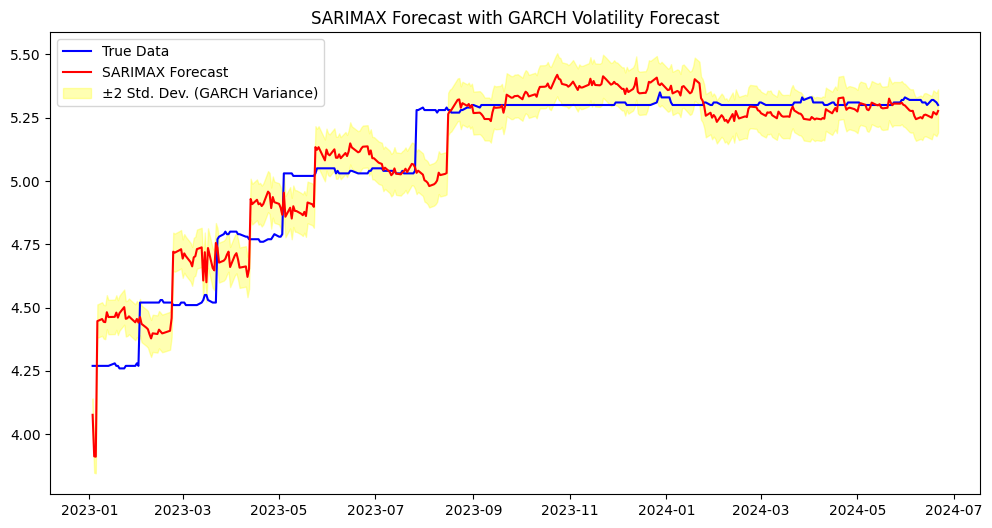

In [238]:
plt.figure(figsize=(12, 6))

# Plot SARIMAX forecast
plt.plot(y_test.index, y_test, label='True Data', color='blue')
plt.plot(y_test.index, sarimax_forecast_mean, label='SARIMAX Forecast', color='red')

# Plot GARCH forecast variance
plt.fill_between(y_test.index,
                 forecast_df['+2 Std. Dev.'],
                 forecast_df['-2 Std. Dev.'],
                 color='yellow', alpha=0.3, label='±2 Std. Dev. (GARCH Variance)')

plt.legend()
plt.title('SARIMAX Forecast with GARCH Volatility Forecast')
plt.show()
